# COVID-19 Mitigation Measures Collateral Damage Assesment 

In this project i will determine which factors are most relevant for the reprodduction of the SARS-CoV2 virus in Austria, built a SIR-based model to simulate various scenarios for different stringency of mitigation measures and then try to estimate the collateral damage by said measures. End product is an estimate for collateral damage of measures and effectiveness in containing the virus

In [1]:
import os
import requests
from pprint import pprint
import covsirphy as cs
import pandas as pd
import numpy as np
import datetime
from operator import add

import scipy.stats as st
from scipy.optimize import curve_fit
from scipy.integrate import odeint
from scipy.stats import ttest_ind
from scipy import signal
from scipy.stats import boxcox
from scipy.stats import normaltest

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.sandbox.regression.predstd import wls_prediction_std

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import r2_score, mean_squared_error, explained_variance_score, mean_squared_log_error


import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
sns.set(rc={'figure.figsize':(15.7,10.27*0.75)})

In [2]:
# Some Sources:
# https://www.who.int/bulletin/online_first/BLT.20.265892.pdf
# https://www.imperial.ac.uk/media/imperial-college/medicine/mrc-gida/2020-03-16-COVID19-Report-9.pdf
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7333368/

## 1. Data Preparation and Exploration

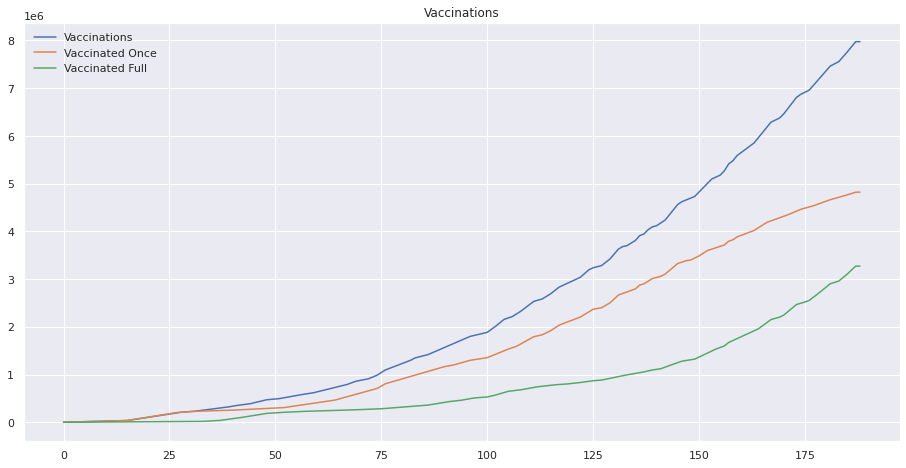

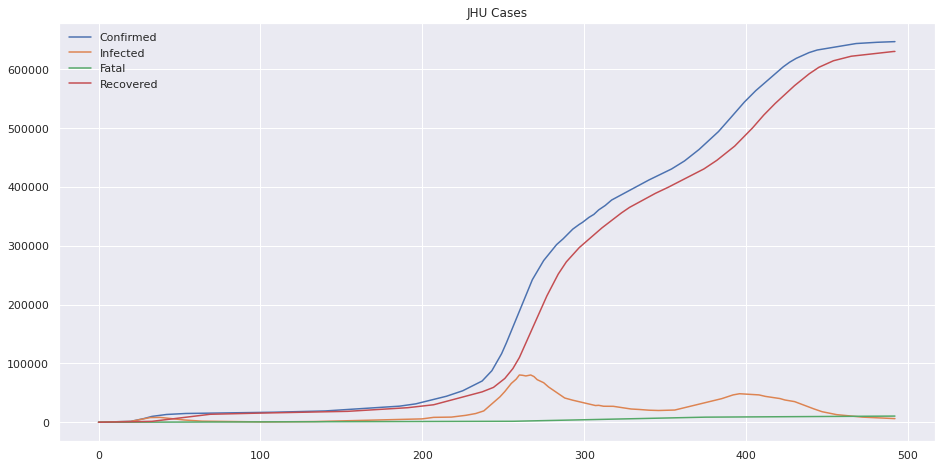

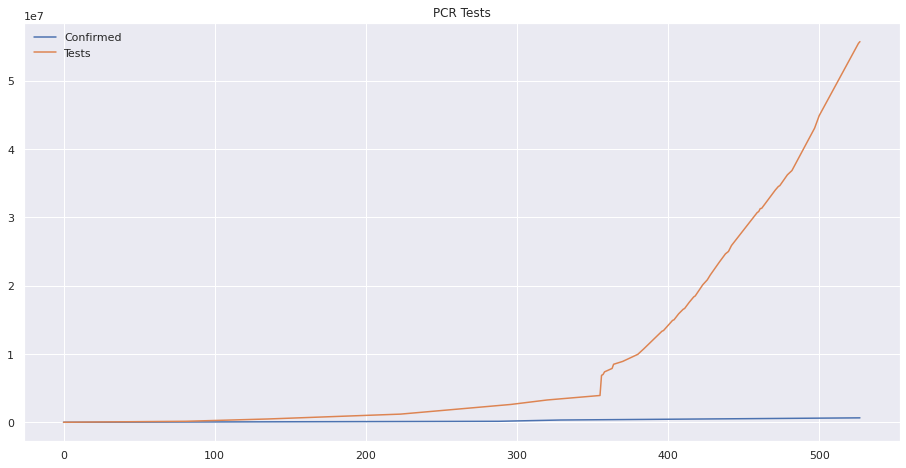

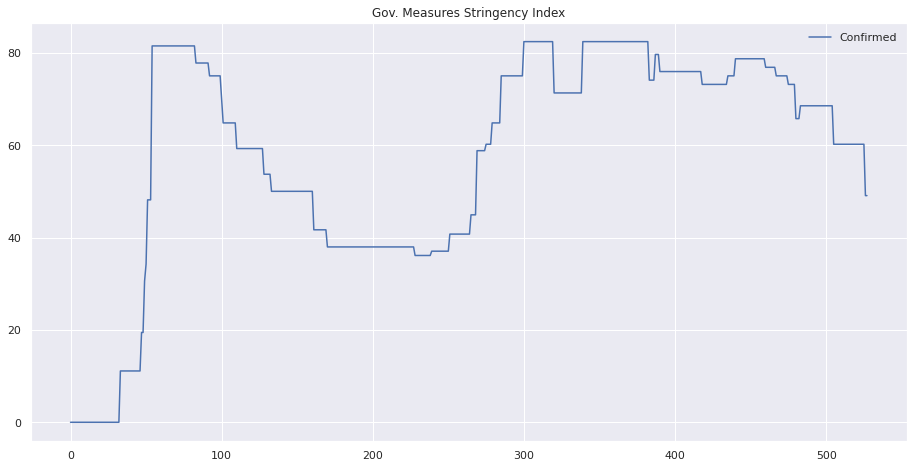

          Date  Population
0   2020-01-22     8840521
1   2020-01-23     8840521
2   2020-01-24     8840521
3   2020-01-25     8840521
4   2020-01-26     8840521
..         ...         ...
523 2021-06-28     8840521
524 2021-06-29     8840521
525 2021-06-30     8840521
526 2021-07-01     8840521
527 2021-07-02     8840521

[528 rows x 2 columns]


In [3]:
#Get data
data_loader = cs.DataLoader("../input")
jhu_data = data_loader.jhu() #Cases (JHU)
population_data = data_loader.population() # Population
oxcgrt_data = data_loader.oxcgrt() # Government Response (OxCGRT)
pcr_data = data_loader.pcr() # Tests
vaccine_data = data_loader.vaccine() # Vaccinations
#print(vaccine_data.subset("Austria"))
plt.plot(vaccine_data.subset("Austria")['Vaccinations'], label='Vaccinations')
plt.plot(vaccine_data.subset("Austria")['Vaccinated_once'], label='Vaccinated Once')
plt.plot(vaccine_data.subset("Austria")['Vaccinated_full'], label='Vaccinated Full')
plt.title('Vaccinations')
plt.legend()
plt.show()

#print(jhu_data.subset("Austria"))
plt.plot(jhu_data.subset("Austria")['Confirmed'], label='Confirmed')
plt.plot(jhu_data.subset("Austria")['Infected'], label='Infected')
plt.plot(jhu_data.subset("Austria")['Fatal'], label='Fatal')
plt.plot(jhu_data.subset("Austria")['Recovered'], label='Recovered')
plt.title('JHU Cases')
plt.legend()
plt.show()

#print(pcr_data.subset("Austria"))
plt.plot(pcr_data.subset("Austria")['Confirmed'], label='Confirmed')
plt.plot(pcr_data.subset("Austria")['Tests'], label='Tests')
plt.title('PCR Tests')
plt.legend()
plt.show()

#print(oxcgrt_data.subset("Austria"))
plt.plot(oxcgrt_data.subset("Austria")['Stringency_index'], label='Confirmed')
plt.title('Gov. Measures Stringency Index')
plt.legend()
plt.show()

country = "Austria"
aut_cov = jhu_data.subset("Austria")
aut_pop = population_data.subset("Austria")
aut_gov = oxcgrt_data.subset("Austria")
aut_pcr = pcr_data.subset("Austria")
aut_vac = vaccine_data.subset("Austria") 
print(aut_pop)

age 0 to 9
age 10 to 19
age 20 to 29
age 30 to 39
age 40 to 49
age 50 to 59
age 60 to 69
age 70 to 79
age 80 to 89
age 90 to 99
age 100 to 109
8901064
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.933
Model:                            OLS   Adj. R-squared (uncentered):              0.914
Method:                 Least Squares   F-statistic:                              49.00
Date:                Sat, 03 Jul 2021   Prob (F-statistic):                    7.65e-05
Time:                        17:52:27   Log-Likelihood:                          17.143
No. Observations:                   9   AIC:                                     -30.29
Df Residuals:                       7   BIC:                                     -29.89
Df Model:                           2                                                  
Covariance Type:            nonrobust                    

/media/lorenz/Volume/ubuntu/anaconda3/envs/p2/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


AltersgruppeID
1        [<5]
2      [5-14]
3     [15-24]
4     [25-34]
5     [35-44]
6     [45-54]
7     [55-64]
8     [65-74]
9     [75-84]
10      [>84]
Name: Altersgruppe, dtype: object
                Anzahl AnzahlGeheilt AnzahlTot AnzEinwohner Altersgruppe  \
AltersgruppeID                                                             
1                 8336          8233         0       433755         [<5]   
2                50993         50528         3       851733       [5-14]   
3                93533         92663         8       941982      [15-24]   
4               104291        103401        14      1208961      [25-34]   
5                97831         97040        33      1185121      [35-44]   
6               111674        110680       166      1308912      [45-54]   
7                84856         83475       609      1285913      [55-64]   
8                40797         38639      1523       872171      [65-74]   
9                33184         29019      3572     

/media/lorenz/Volume/ubuntu/anaconda3/envs/p2/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


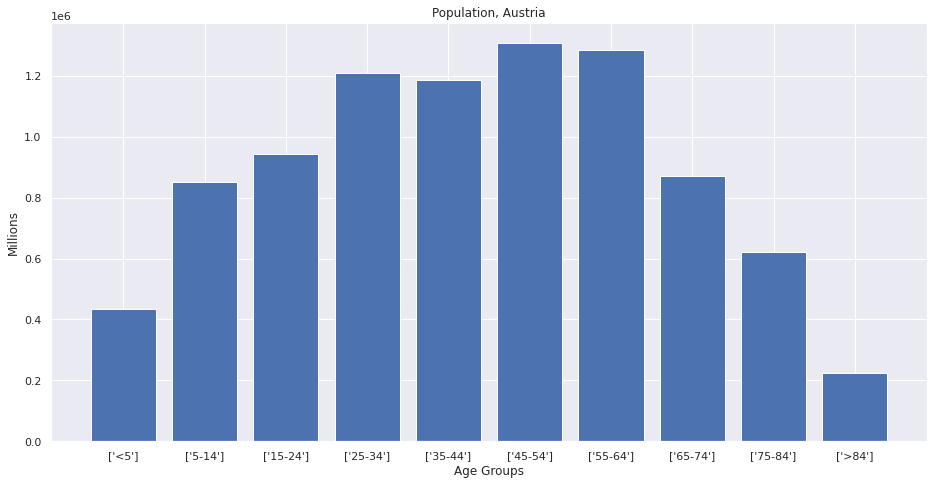

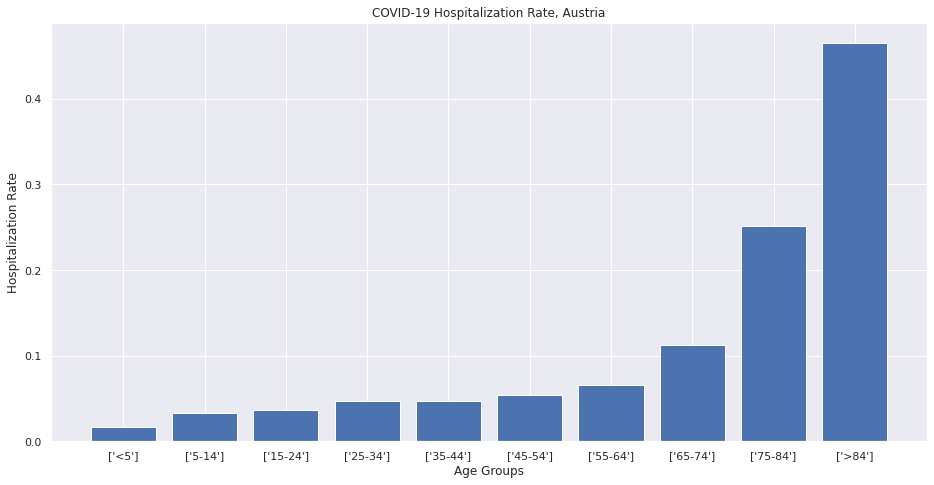

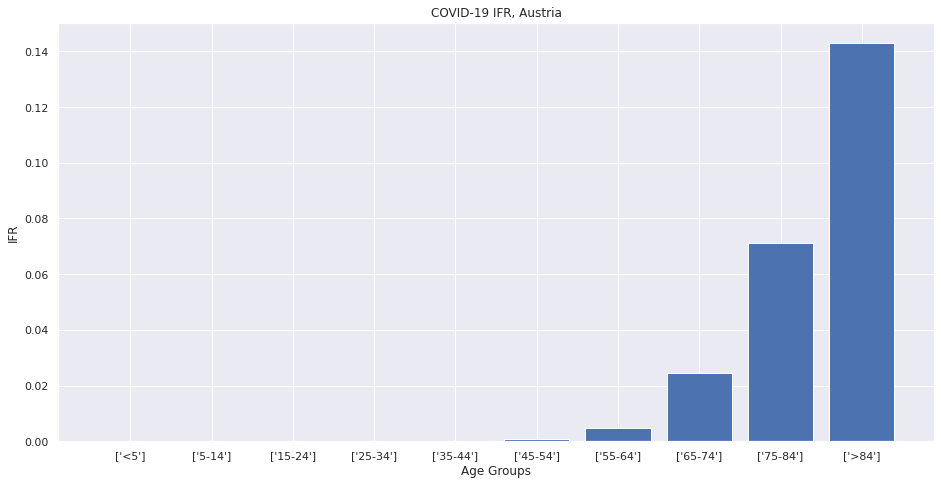

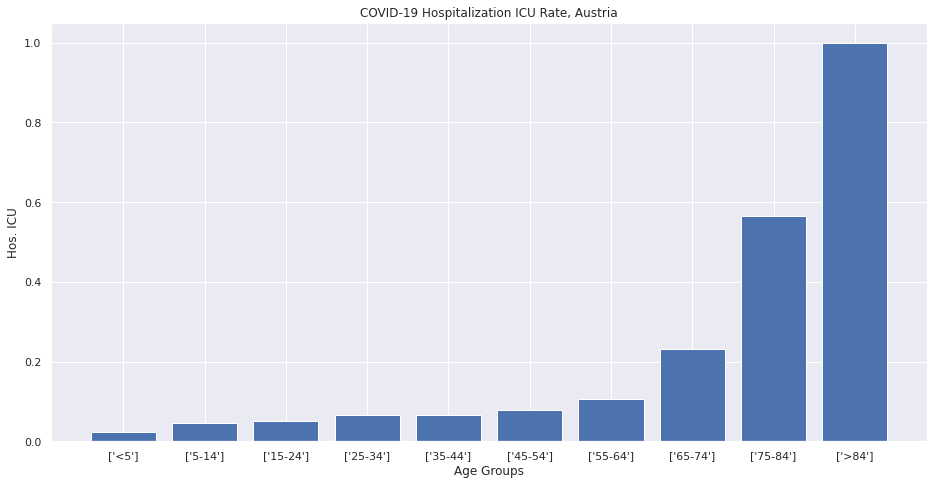

In [4]:
'''
Für die Todesrate von Krankheiten gibt es laut WHO zwei verschiedene wichtige Kennzahlen. 
Mit dem „Fall-Verstorbenen-Anteil” (CFR) wird berechnet, wie viele Todesfälle unter 
allen positiv getesteten Erkrankten zu verzeichnen sind. 
Beim „Infizierten-Verstorbenen-Anteil” (IFR) wird die Zahl der Todesfälle der geschätzten Zahl 
an Gesamtinfizierten gegenübergestellt. Dadurch werden auch Infizierte erfasst, 
die keine oder kaum Symptome aufzeigen und nicht getestet wurden.
'''

# https://corona-ampel.gv.at/sites/corona-ampel.gv.at/files/Kommission_20210311_Sitzungsergebnis.pdf

from zipfile import ZipFile
# Population
# https://www.statistik.at/web_de/statistiken/menschen_und_gesellschaft/bevoelkerung/bevoelkerungsstruktur/bevoelkerung_nach_alter_geschlecht/index.html
dfs = pd.read_excel("./data/bevoelkerung_am_1.1.2020_nach_alter_und_bundesland_-_insgesamt.xlsx", sheet_name=None)
dfs = dfs['Insgesamt'][['Bevölkerung am 1.1.2020 nach Alter und Bundesland - Insgesamt', 'Unnamed: 1']].loc[4:104]
dfs = dfs.reset_index(drop=True)

pop_groups = []
for i in range(0,104,10):
    print('age',i,'to',i+9)
    pop_groups.append(dfs['Unnamed: 1'].loc[i:i+9].sum())

pp80 = sum(pop_groups[-3:])
pop_groups = pop_groups[:-3]
pop_groups.append(pp80)
assert(sum(pop_groups)==dfs['Unnamed: 1'].sum())
print(sum(pop_groups))

#Some Data from birtain -  we will try to obtain hosp rates, icu rates from that data for austria
# Source:
# https://www.imperial.ac.uk/media/imperial-college/medicine/mrc-gida/2020-03-16-COVID19-Report-9.pdf
pop_groups_ifr = [0.00002, 0.00006, 0.0003, 0.0008, 0.0015, 0.006, 0.022, 0.051, 0.093]
pop_groups_hosp = [0.001, 0.003, 0.012, 0.032, 0.049, 0.102, 0.166, 0.243, 0.273]
pop_groups_hosp_icu = [0.05, 0.05, 0.05, 0.05, 0.063, 0.122, 0.274, 0.432, 0.703]

#print(pop_groups)
#print(pop_groups_ifr)
#print(pop_groups_hosp)
#print(pop_groups_hosp_icu)

mod = sm.OLS(pop_groups_hosp, np.array([pop_groups_ifr, pop_groups]).T)
res = mod.fit()
print(res.summary())
#res.predict(np.array([pop_groups_ifr, pop_groups]).T)
        
# Get IFRs, etc for austria
# https://flexikon.doccheck.com/de/Infection_fatality_rate
url = 'https://covid19-dashboard.ages.at/data/data.zip'
save_path = './data/ages/data.zip'

def download_url(url, save_path, chunk_size=128):
    r = requests.get(url, stream=True)
    with open(save_path, 'wb') as fd:
        for chunk in r.iter_content(chunk_size=chunk_size):
            fd.write(chunk)

download_url(url, save_path)
with ZipFile('./data/ages/data.zip', 'r') as zipObj:
    zipObj.extractall(path='./data/ages/')

aut_age_groups = pd.read_csv("./data/ages/CovidFaelle_Altersgruppe.csv", sep=';', index_col = 0, header = 0)

print(aut_age_groups.loc[aut_age_groups['BundeslandID'] <= 9].groupby(['AltersgruppeID']).Altersgruppe.unique())


aut_age_groups = pd.DataFrame(
    [aut_age_groups.loc[aut_age_groups['BundeslandID'] <= 9].groupby(['AltersgruppeID']).Anzahl.sum(),
    aut_age_groups.loc[aut_age_groups['BundeslandID'] <= 9].groupby(['AltersgruppeID']).AnzahlGeheilt.sum(),
    aut_age_groups.loc[aut_age_groups['BundeslandID'] <= 9].groupby(['AltersgruppeID']).AnzahlTot.sum(),
    aut_age_groups.loc[aut_age_groups['BundeslandID'] <= 9].groupby(['AltersgruppeID']).AnzEinwohner.sum(),
    aut_age_groups.loc[aut_age_groups['BundeslandID'] <= 9].groupby(['AltersgruppeID']).Altersgruppe.unique()
    ]
).T#.reset_index(drop=True)

# Percentage asymptomatic cases:
# https://corona-ampel.gv.at/sites/corona-ampel.gv.at/files/Kommission_20210311_Sitzungsergebnis.pdf
aut_age_groups['CFR'] = aut_age_groups.AnzahlTot/aut_age_groups.Anzahl
aut_age_groups['IFR'] = aut_age_groups['CFR']*(1-0.34) #percentage of asymptomatic
aut_age_groups['Hosp'] = np.clip(
    res.predict(np.array([aut_age_groups['IFR'], aut_age_groups['AnzEinwohner']]).T),
    0.0,1.0)
print(aut_age_groups)

aut_hosp_groups = pd.read_csv("./data/ages/CovidFallzahlen.csv", sep=';', index_col = 0, header = 0,
                dtype  = {'Datum' : str, 'R_eff': str, 'R_eff_lwr' : str, 'R_eff_upr' : str} )
print(aut_hosp_groups.head(15))

aut_hosp_groups = pd.DataFrame(
    [aut_hosp_groups.loc[aut_hosp_groups['BundeslandID'] == 10].FZHosp,
     aut_hosp_groups.loc[aut_hosp_groups['BundeslandID'] == 10].FZHospFree,
     aut_hosp_groups.loc[aut_hosp_groups['BundeslandID'] == 10].FZICU,
     aut_hosp_groups.loc[aut_hosp_groups['BundeslandID'] == 10].FZICUFree,
    ]
).T


mod = sm.OLS(pop_groups_hosp_icu, np.array([pop_groups_hosp, pop_groups_ifr, pop_groups]).T)
res = mod.fit()
print(res.summary())
aut_age_groups['Hosp_ICU'] = np.clip(res.predict(np.array([
                                aut_age_groups['Hosp'],
                                aut_age_groups['IFR'], 
                                aut_age_groups['AnzEinwohner']]).T), 0.0, 1.0)
    

x = np.linspace(0, len(aut_age_groups['IFR']), len(aut_age_groups['IFR']), endpoint=False, dtype=int)

plt.xlabel('Age Groups')
plt.ylabel('Millions')
plt.title('Population, Austria')
plt.bar(x, aut_age_groups['AnzEinwohner'], tick_label=aut_age_groups['Altersgruppe'])
plt.show()


plt.xlabel('Age Groups')
plt.ylabel('Hospitalization Rate')
plt.title('COVID-19 Hospitalization Rate, Austria')
plt.bar(x, aut_age_groups['Hosp'], 
        tick_label=aut_age_groups['Altersgruppe'])
plt.show()

x = np.linspace(0, len(aut_age_groups['IFR']), len(aut_age_groups['IFR']), endpoint=False, dtype=int)
plt.xlabel('Age Groups')
plt.ylabel('IFR')
plt.title('COVID-19 IFR, Austria')
plt.bar(x, aut_age_groups['IFR'], tick_label=aut_age_groups['Altersgruppe'])
plt.show()

x = np.linspace(0, len(aut_age_groups['IFR']), len(aut_age_groups['IFR']), endpoint=False, dtype=int)
plt.xlabel('Age Groups')
plt.ylabel('Hos. ICU')
plt.title('COVID-19 Hospitalization ICU Rate, Austria')
plt.bar(x, aut_age_groups['Hosp_ICU'], tick_label=aut_age_groups['Altersgruppe'])
plt.show()
        
pop_groups_hosp_icu = aut_age_groups['Hosp_ICU'].to_numpy()
pop_groups_hosp = aut_age_groups['Hosp'].to_numpy()
pop_groups_ifr = aut_age_groups['IFR'].to_numpy()
pop_groups = aut_age_groups['AnzEinwohner'].to_numpy()

         Date  Vaccinations  Vaccinated_once  Vaccinated_full
0  2020-12-27           739              739                0
1  2020-12-28          2052             2052                0
2  2020-12-29          3677             3677                0
3  2020-12-30          5039             5039                0
4  2020-12-31          5049             5049                0
5  2021-01-01          5056             5056                0
6  2021-01-02          5064             5064                0
7  2021-01-03          5070             5070                0
8  2021-01-04          5192             5192                0
9  2021-01-05          6998             6998                0
10 2021-01-06          7853             7853                0
11 2021-01-07         11126            11126                0
12 2021-01-08         24214            24214                0
13 2021-01-09         28686            28686                0
14 2021-01-10         30931            30931                0
15 2021-

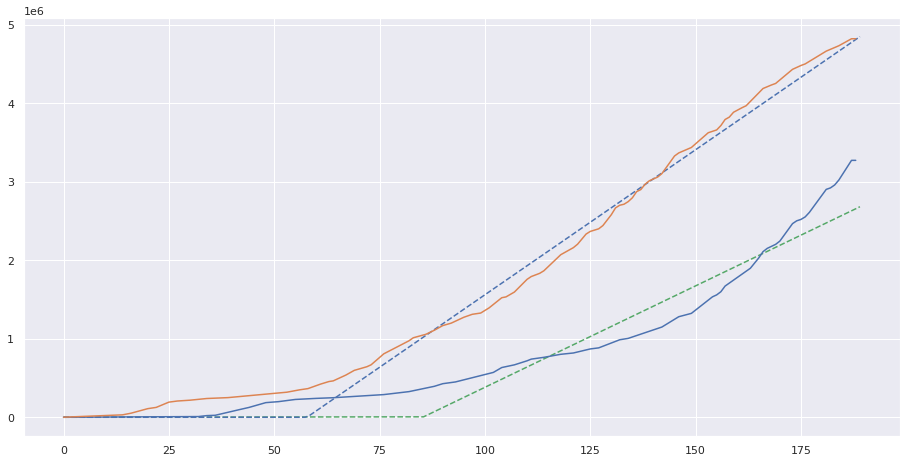

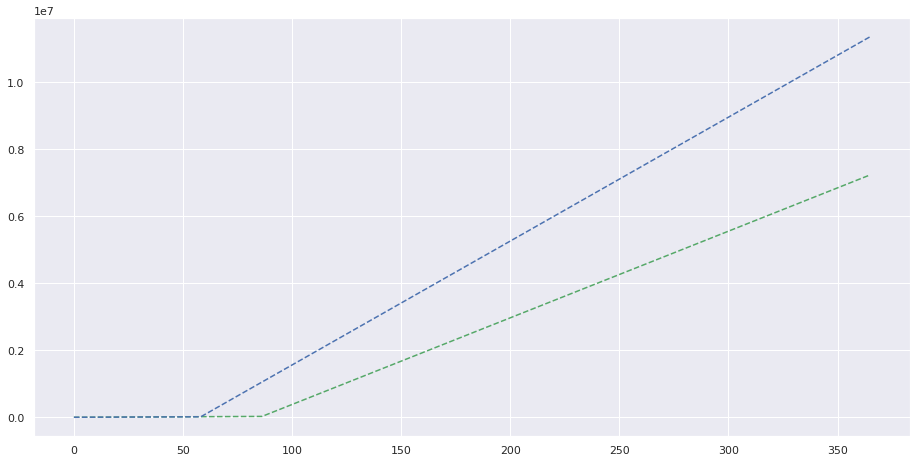

37044.71674553305 25910.179796511307


In [5]:
# Vaccines
print(aut_vac.head(25))
vac_full_data = aut_vac['Vaccinated_full'].to_numpy()
vac_once_data = aut_vac['Vaccinated_once'].to_numpy()
# plt.plot(aut_vac['Vaccinated_full'].to_numpy())

# Start Date is 2020-12-27 for vaccinated once, 
# 2021-01-15 for vaccinated
# 307 days and XXX days after start of pandemic in Austria on 25.02.2020

# Next we fit a 4th degree polynomial to the vaccinations curve using least squares method
# so we can estimate future vaccinations progress.

#poly4 = lambda x, a, b, c, d, e: a*(x**4) + b*(x**3) + c*(x**2) + d*(x**2) + e
#def func(x, a, b, c, d, e):
#    y = poly4(x, a, b, c, d, e)
#    return np.abs(y*(y>0))
    
#poly3 = lambda x, a, b, c, d: a*(x**3) + b*(x**2) + c*(x**1) + d*(x**0) 
#def func(x, a, b, c, d):
#    y = poly3(x, a, b, c, d)
#    return np.abs(y*(y>0))

#poly2 = lambda x, a, b, c: a*(x**2) + b*(x**1) + c*(x**0)
#def func(x, a, b, c):
#    y = poly2(x, a, b, c)
#    return np.abs(y*(y>0))

poly1 = lambda x, a, b: a*(x**1) + b*(x**0)
def vac_full(x, a, b):
    y = poly1(x, a, b)
    return np.abs(y*(y>0))

poly1 = lambda x, a, b: a*(x**1) + b*(x**0)
def vac_once(x, a, b):
    y = poly1(x, a, b)
    return np.abs(y*(y>0))
    
    

xdata = np.linspace(0,1,len(vac_full_data))*len(vac_full_data)
popt_full, pcov_full = curve_fit(vac_full, xdata, vac_full_data, method='lm')

xdata = np.linspace(0,1,len(vac_once_data))*len(vac_once_data)
popt_once, pcov_once = curve_fit(vac_once, xdata, vac_once_data, method='lm')

# Check quality of fit with R2
print(r2_score(vac_full(xdata, *popt_full), vac_full_data))
plt.plot(xdata, vac_full(xdata, *popt_full), 'g--')
plt.plot(xdata, vac_once(xdata, *popt_once), 'b--')
plt.plot(vac_full_data)
plt.plot(vac_once_data)
plt.show()

# Predict a whole year of vaccinations and see how it looks like:
dur = 365
xdata = np.linspace(0,1,dur)*dur
plt.plot(xdata, vac_full(xdata, *popt_full), 'g--')
plt.plot(xdata, vac_once(xdata, *popt_once), 'b--')
plt.show()

vac_full_curve = vac_full(xdata, *popt_full)
vac_full_per_day = vac_full_curve[-1]-vac_full_curve[-2]

vac_once_curve = vac_once(xdata, *popt_once)
vac_once_per_day = vac_once_curve[-1]-vac_once_curve[-2]
print(vac_once_per_day, vac_full_per_day)

               R_eff  R_eff_lwr  R_eff_upr
Datum                                     
2020-03-10  2.184247   1.895462   2.493209
2020-03-11  2.566776   2.289402   2.859781
2020-03-12  2.494346   2.257588   2.742740
2020-03-13  2.631449   2.422677   2.848726
2020-03-14  2.574769   2.398659   2.757029


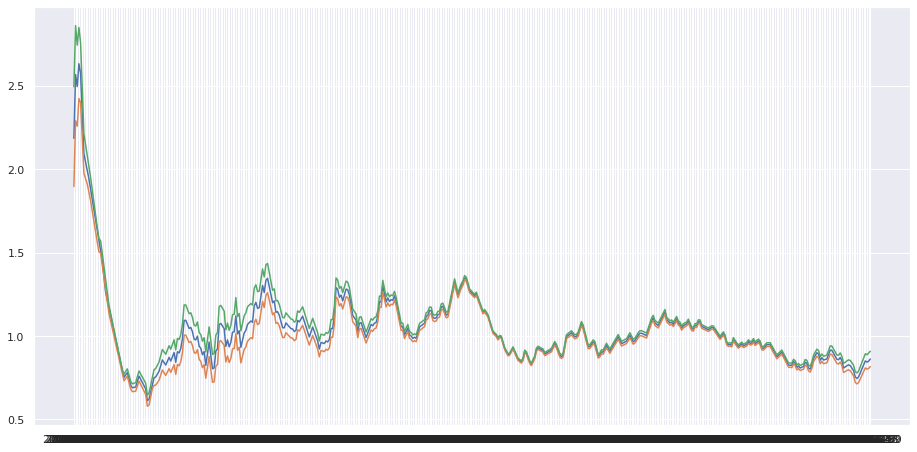

In [6]:
# Effective reproduction number, etc AGES
# https://www.ages.at/en/wissen-aktuell/publikationen/epidemiologische-parameter-des-covid19-ausbruchs-oesterreich-20202021/

urls = ['https://www.ages.at/fileadmin/AGES2015/Wissen-Aktuell/COVID19/growth.csv',
     'https://www.ages.at/fileadmin/AGES2015/Wissen-Aktuell/COVID19/R_eff.csv',
     'https://www.ages.at/fileadmin/AGES2015/Wissen-Aktuell/COVID19/R_eff_bundesland.csv',
     'https://www.ages.at/fileadmin/AGES2015/Wissen-Aktuell/COVID19/meta_data.csv'
    ]

for url in urls:
    with open('./data/ages/'+os.path.split(url)[1], 'wb') as f, \
            requests.get(url, stream=True) as r:
        for line in r.iter_lines():
            f.write(line+'\n'.encode())

aut_reff = pd.read_csv("./data/ages/R_eff.csv", sep=';', index_col = 0, header = 0,
                dtype  = {'Datum' : str, 'R_eff': str, 'R_eff_lwr' : str, 'R_eff_upr' : str} ) 
aut_reff[0:]=aut_reff[0:].replace({',' : '.'}, regex=True).astype(float)
print(aut_reff.head())

plt.plot(aut_reff['R_eff'], label='R_eff')
plt.plot(aut_reff['R_eff_lwr'], label='R_eff_lwr')
plt.plot(aut_reff['R_eff_upr'], label='R_eff_upr')
plt.show()

Int64Index([202003, 202004, 202005, 202006, 202007, 202008, 202009, 202010,
            202011, 202012, 202101, 202102],
           dtype='int64', name='REF_DATE')
Index(['NUTS1', 'NUTS2', 'NUTS3', 'DISTRICT_CODE', 'SUB_DISTRICT_CODE', 'T',
       'T_MAX', 'T_MIN', 'MEAN_T_MAX', 'MEAN_T_MIN', 'NUM_FROST', 'NUM_ICE',
       'NUM_SUMMER', 'NUM_HEAT', 'P', 'P_MAX', 'P_MIN', 'SUN_H', 'NUM_CLEAR',
       'NUM_CLOUD', 'REL_HUM', 'REL_HUM_MAX', 'REL_HUM_MIN', 'WIND_VEL',
       'NUM_WIND_VEL60', 'WIND_VEL_MAX', 'PRECP_SUM', 'NUM_PRECP_01',
       'STAT_NUM', 'Unnamed: 30', 'Unnamed: 31'],
      dtype='object')


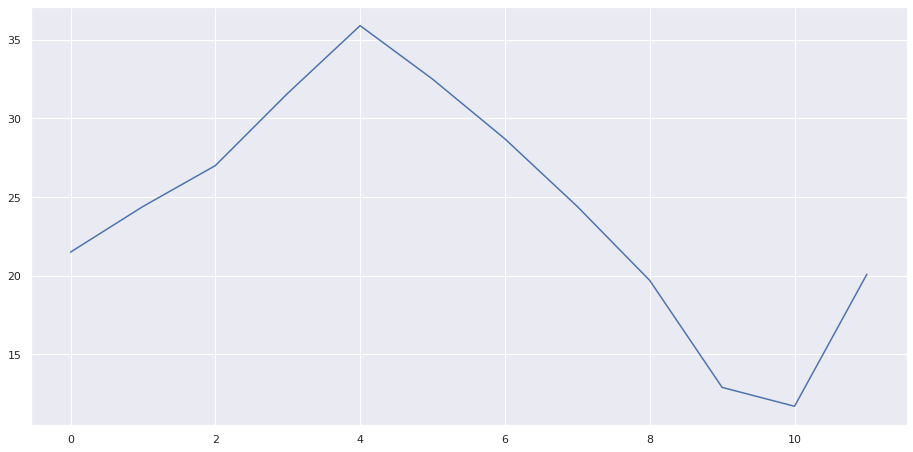

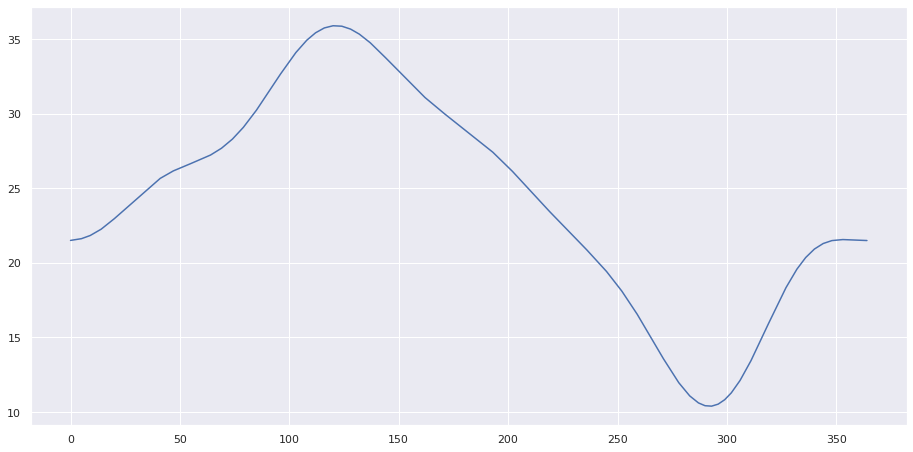

In [7]:
# Some papers suggest association between temperatures and virus spread
# https://repositum.tuwien.at/bitstream/20.500.12708/17056/1/Prager%20Lukas%20-%202021%20-%20Examining%20Austrian%20COVID-19%20Data%20in%20the%20Context%20of%20Linear...pdf#%5B%7B%22num%22%3A1106%2C%22gen%22%3A0%7D%2C%7B%22name%22%3A%22XYZ%22%7D%2C72%2C628.0339966%2Cnull%5D
# https://www.sciencedirect.com/science/article/pii/S0048969720379213
# https://www.sciencedirect.com/science/article/pii/S1201971220302848

url = 'https://www.wien.gv.at/gogv/l9ogdwetter'
with open('./data/wiengv/'+os.path.split(url)[1], 'wb') as f, \
            requests.get(url, stream=True) as r:
        for line in r.iter_lines():
            f.write(line+'\n'.encode())
            
aut_weather= pd.read_csv("./data/wiengv/l9ogdwetter", sep=';', index_col = 0, header = 1)
aut_weather[aut_weather.columns[5:29]] = aut_weather[aut_weather.columns[5:29]].replace({',' : '.'}, regex=True).astype(float)
print(aut_weather.index[782:782+12]) #which rows to select for data since march 1 2020
print(aut_weather.columns)
X_w = aut_weather[aut_weather.columns[6]].iloc[782:782+12].to_numpy()
plt.plot(X_w)
plt.show()
X_w = signal.resample(X_w, aut_reff['R_eff'].iloc[0:365].to_numpy().shape[0])
plt.plot(X_w)
plt.show()

#avg over last 3 yrs
#X_w += signal.resample(aut_weather[aut_weather.columns[6]].iloc[782-12:782-12+11].to_numpy(), 
#                      aut_reff['R_eff'].iloc[0:365].to_numpy().shape[0])

#X_w += signal.resample(aut_weather[aut_weather.columns[6]].iloc[782-24:782-24+11].to_numpy(), 
#                      aut_reff['R_eff'].iloc[0:365].to_numpy().shape[0])

#X_w= X_w/3

#plt.plot(X_w)
#plt.show()

## Regression analysis of variables

In [8]:
# Remove Colinear Variables
# https://stats.stackexchange.com/questions/155028/how-to-systematically-remove-collinear-variables-pandas-columns-in-python
# https://www.statsmodels.org/stable/generated/statsmodels.stats.outliers_influence.variance_inflation_factor.html   

def calculate_vif_(X, thresh=5.0):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = []
        for ix in range(X.iloc[:, variables].shape[1]):
            try:
                vif_ix = variance_inflation_factor(X.iloc[:, variables].values, ix)
                vif.append(vif_ix)
            except:
                vif.append(thresh+1.0)

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True

    print('Remaining variables:')
    print(X.columns[variables])
    return X.iloc[:, variables]

In [182]:
# Regression analysis
# Goodness of fit --> R2
# Significance F-Test overall, t-tests individual params.
# Evaluate OLS model on all features via F/t-testing
# Interpretation:
# https://medium.com/@jyotiyadav99111/statistics-how-should-i-interpret-results-of-ols-3bde1ebeec01
# https://medium.com/analytics-vidhya/how-to-interpret-result-from-linear-regression-3f7ae7679ef9
# https://de.wikipedia.org/wiki/Testen_allgemeiner_linearer_Hypothesen#Einzelgleichungsmodell
# https://statisticsbyjim.com/regression/interpret-coefficients-p-values-regression/
# https://en.wikipedia.org/wiki/Regression_analysis

# Effective reproduction number
y = aut_reff['R_eff'].iloc[0:365].to_numpy()
y_lwr = aut_reff['R_eff_lwr'].iloc[0:365].to_numpy()
y_upr = aut_reff['R_eff_upr'].iloc[0:365].to_numpy()

# Pandemic
X_p = pd.DataFrame(aut_cov['Infected'].iloc[0:365], columns=['Infected'])
X_p = pd.concat((X_p, pd.DataFrame(aut_cov['Fatal'].iloc[0:365], columns=['Fatal'])), axis=1)
X_p = pd.concat((X_p, pd.DataFrame(aut_cov['Recovered'].iloc[0:365], columns=['Recovered'])), axis=1)
X_p = pd.concat((X_p, pd.DataFrame(aut_cov['Confirmed'].iloc[0:365], columns=['Confirmed'])), axis=1)

# Gov. measures from oxford tracker
#print(aut_gov.head())
oxgrt = pd.read_csv('./data/oxgrt/OxCGRT_latest.csv')
cols = oxgrt.columns
cols = [col for col in cols[6:] if 'Flag' not in col and 'Wildcard' not in col]
oxgrt2 = oxgrt.loc[oxgrt['CountryName'] == 'Austria']
oxgrt2 = oxgrt2[cols].iloc[69:69+365]
oxgrt2.reset_index(inplace=True, drop=True)
oxgrt2 = oxgrt2.fillna(method="pad")
X_g = oxgrt2[oxgrt2.columns[:20]]
X_g.columns = [''.join(col.split('_')[1:]).replace(' ', '_').replace('/', '_') for col in X_g.columns]
#X_g = aut_gov[69-21:(69-21+365)][aut_gov.columns[1:]].reset_index(drop=True) #10 march
      
# Weather data from Hohe Warte (ZAMG unfortunately has a paywall...)
X_w = aut_weather.iloc[782:782+12][aut_weather.columns[5:28]]
X_w = signal.resample(X_w, y.shape[0])
X_w = pd.DataFrame(X_w, columns = aut_weather.columns[5:28])
X_w_c = calculate_vif_(X_w) # Remove multicolinear columns from weather data 
print(X_w, X_g)
# Merge datasets analyse them togather
X_wgp = pd.concat((X_w, X_g, X_p), axis=1)
X_wg = pd.concat((X_w, X_g), axis=1)
X_gp = pd.concat((X_g, X_p), axis=1)
X_wp = pd.concat((X_w, X_p), axis=1)

X_w_cgp = pd.concat((X_w_c, X_g, X_p), axis=1)
X_w_cg = pd.concat((X_w_c, X_g), axis=1)
X_w_cp = pd.concat((X_w_c, X_p), axis=1)

/media/lorenz/Volume/ubuntu/anaconda3/envs/p2/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


dropping 'T' at index: 0
dropping 'T_MAX' at index: 0
dropping 'T_MIN' at index: 0
dropping 'MEAN_T_MAX' at index: 0
dropping 'MEAN_T_MIN' at index: 0
dropping 'NUM_FROST' at index: 0
dropping 'NUM_ICE' at index: 0
dropping 'NUM_SUMMER' at index: 0
dropping 'NUM_HEAT' at index: 0
dropping 'P' at index: 0
dropping 'P_MAX' at index: 0
dropping 'REL_HUM_MAX' at index: 5
dropping 'P_MIN' at index: 0
dropping 'REL_HUM' at index: 3
dropping 'WIND_VEL' at index: 4
dropping 'WIND_VEL_MAX' at index: 5
dropping 'NUM_PRECP_01' at index: 6
dropping 'REL_HUM_MIN' at index: 3
dropping 'SUN_H' at index: 0
dropping 'NUM_WIND_VEL60' at index: 2
Remaining variables:
Index(['NUM_CLEAR', 'NUM_CLOUD', 'PRECP_SUM'], dtype='object')
            T      T_MAX     T_MIN  MEAN_T_MAX  MEAN_T_MIN  NUM_FROST  \
0    7.300000  21.500000 -2.700000   12.900000    3.200000   7.000000   
1    7.505590  21.511729 -2.590924   13.181167    3.324983   6.857942   
2    7.711580  21.528904 -2.492582   13.463442    3.448322   

In [10]:
'''
# Analyse all datsets seperately w.r.t Reproduction
x = np.linspace(0, 365, 365)
dependent = {'R_lwr': y_lwr, 'R': y, 'R_upr': y_upr}
independent = {'X_w': X_w, 'X_p': X_p, 'X_g': X_g,
               'X_w_c' : X_w_c, 'X_wgp' : X_wgp, 'X_wg' : X_wg, 
               'X_gp' : X_gp, 'X_wp' : X_wp, 'X_w_cgp' : X_w_cgp,
               'X_w_cg' : X_w_cg, 'X_w_cp': X_w_cp}
for X_key in independent:
    for y_key in dependent:
        print("{}, {}".format(X_key, y_key))
        mod = sm.OLS(dependent[y_key], independent[X_key])
        res = mod.fit()
        print(res.summary())

        prstd, iv_l, iv_u = wls_prediction_std(res)
        y_pred = res.predict(independent[X_key])
        fig, ax = plt.subplots(figsize=(8,6))
        ax.plot(x, y_pred, 'o', label="data")
        ax.plot(x, dependent[y_key], 'b-', label="True")
        ax.plot(x, res.fittedvalues, 'r--.', label="OLS")
        ax.plot(x, iv_u, 'r--')
        ax.plot(x, iv_l, 'r--')
        ax.legend(loc='best');
        plt.show()
        
# ...w.r.t pandemic curve
dependent = {'Fatal': X_p['Fatal'], 'Infected': X_p['Infected'], 
             'Recovered': X_p['Recovered'], 'Confirmed' : X_p['Confirmed']}
independent = {'X_w': X_w, 'X_g': X_g,
               'X_w_c' : X_w_c, 'X_wg' : X_wg, 
               'X_gp' : X_gp, 'X_w_cg' : X_w_cg}
for X_key in independent:
    for y_key in dependent:
        print("{}, {}".format(X_key, y_key))
        mod = sm.OLS(dependent[y_key], independent[X_key])
        res = mod.fit()
        print(res.summary())

        prstd, iv_l, iv_u = wls_prediction_std(res)
        y_pred = res.predict(independent[X_key])
        fig, ax = plt.subplots(figsize=(8,6))
        ax.plot(x, y_pred, 'o', label="data")
        ax.plot(x, dependent[y_key], 'b-', label="True")
        ax.plot(x, res.fittedvalues, 'r--.', label="OLS")
        ax.plot(x, iv_u, 'r--')
        ax.plot(x, iv_l, 'r--')
        ax.legend(loc='best');
        plt.show()
'''

'\n# Analyse all datsets seperately w.r.t Reproduction\nx = np.linspace(0, 365, 365)\ndependent = {\'R_lwr\': y_lwr, \'R\': y, \'R_upr\': y_upr}\nindependent = {\'X_w\': X_w, \'X_p\': X_p, \'X_g\': X_g,\n               \'X_w_c\' : X_w_c, \'X_wgp\' : X_wgp, \'X_wg\' : X_wg, \n               \'X_gp\' : X_gp, \'X_wp\' : X_wp, \'X_w_cgp\' : X_w_cgp,\n               \'X_w_cg\' : X_w_cg, \'X_w_cp\': X_w_cp}\nfor X_key in independent:\n    for y_key in dependent:\n        print("{}, {}".format(X_key, y_key))\n        mod = sm.OLS(dependent[y_key], independent[X_key])\n        res = mod.fit()\n        print(res.summary())\n\n        prstd, iv_l, iv_u = wls_prediction_std(res)\n        y_pred = res.predict(independent[X_key])\n        fig, ax = plt.subplots(figsize=(8,6))\n        ax.plot(x, y_pred, \'o\', label="data")\n        ax.plot(x, dependent[y_key], \'b-\', label="True")\n        ax.plot(x, res.fittedvalues, \'r--.\', label="OLS")\n        ax.plot(x, iv_u, \'r--\')\n        ax.plot(x, i

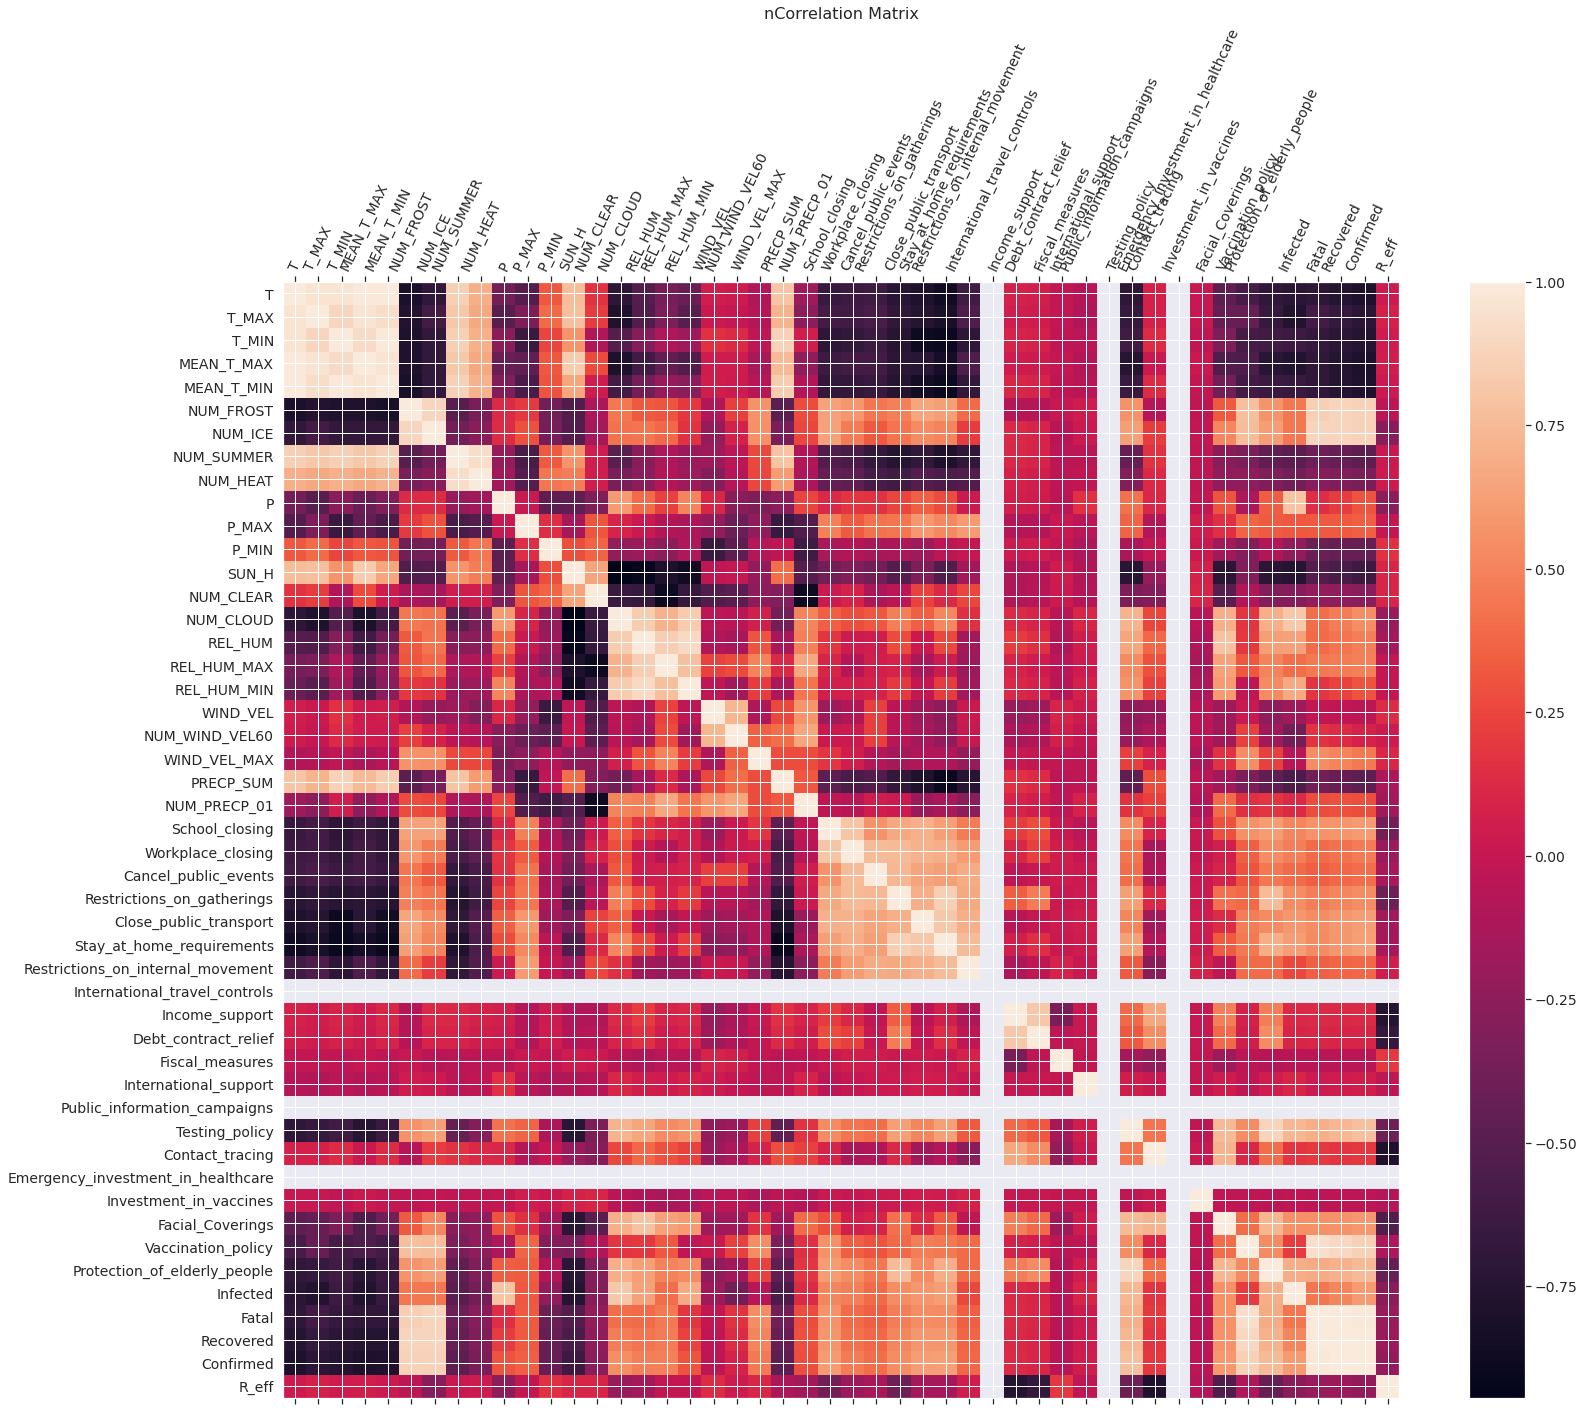

In [11]:
# Explore X, y datasets visually
Xy = pd.concat((X_wgp, pd.DataFrame(y, columns=['R_eff'])), axis=1)
Xy.reset_index(drop=True, inplace=True)

f = plt.figure(figsize=(25, 20))
plt.matshow(pd.DataFrame(Xy, columns=Xy.columns).corr(), fignum=f.number)
plt.xticks(range(Xy.select_dtypes(['number']).shape[1]), 
           Xy.select_dtypes(['number']).columns, fontsize=14, rotation=65)
plt.yticks(range(Xy.select_dtypes(['number']).shape[1]), 
           Xy.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('nCorrelation Matrix', fontsize=16);
plt.show()

## Based on above insights, build a model for R_eff

In [23]:
# Find best weather features

select_k = 12 #len(X_w.columns)
#mutual_info_regression, f_regression
selector = SelectKBest(score_func=f_regression, k=select_k)
scaler = MinMaxScaler()
X_w = pd.DataFrame(scaler.fit_transform(X_w), columns=X_w.columns)
X_best = selector.fit_transform(X_w, y)
mask = selector.get_support() #list of booleans
features = [] # The list of your K best features
for bool, feature in zip(mask, X_w.columns):
    if bool:
        features.append(feature)
print('\nSelected k Reg. Features:', features)
X_w_best = pd.DataFrame(X_best, columns=features)

# Try to build a good regressor
X = X_w_best#calculate_vif_(X_w_best, 5)


# Feature Engineering
# https://towardsdatascience.com/feature-engineering-for-machine-learning-3a5e293a5114

import scipy.stats as st
kernlen=2
nsig=1
k = np.linspace(-nsig, nsig, kernlen+1)
kern1d = np.diff(st.norm.cdf(k))
pd.options.mode.chained_assignment = None 
for col in X.columns:
    X["{}_log+1".format(col)] = (X[col]+1).transform(np.log) # Log transform
    X["{}_conv".format(col)] = np.convolve(X[col], kern1d, 'same') # Convolution
    X["{}_pow2".format(col)] = X[col]*X[col] # Power transform


scaler = MinMaxScaler()
X_g = pd.DataFrame(scaler.fit_transform(X_g), columns=X_g.columns)
X = pd.concat((X, X_g), axis=1)

# Remove statistically insignificant (p 0.05) features, they could break the model
# As well as features that ca be judged irellevant from domain knowledge
irrelevant = []
irrelevant = [
        'Debt_contract_relief',
        'Fiscal_measures', 
        'International_support', 
        'Income_support', 
        'Emergency_investment_in_healthcare',
        'Investment_in_vaccines',
        'Vaccination_policy']
X.drop(irrelevant, axis=1, inplace=True)
X.drop(irrelevant, axis=1, inplace=True)
repeat = True
while repeat:
    mod = sm.OLS(y, X)
    res = mod.fit()
    repeat = False
    idx_max, p_max = 0.0, 0.05
    for i in range(len(res.pvalues.index.tolist())):
        
        if res.pvalues[i] > p_max and res.pvalues.index.tolist()[i] not in X_g.columns:
            p_max = res.pvalues[i]
            idx_max = i
            repeat = True
    if repeat:
        X.drop([res.pvalues.index.tolist()[idx_max]], axis=1, inplace=True)
print(X.columns)

mod = sm.OLS(y, X)
res = mod.fit()
prstd, iv_l, iv_u = wls_prediction_std(res)
y_pred = res.predict(X)
x = np.linspace(0, len(y), len(y_pred))
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x, y_pred, 'o', label="data")
ax.plot(x, y, 'b-', label="True")
ax.plot(x, res.fittedvalues, 'r--.', label="OLS")
ax.plot(x, iv_u, 'r--')
ax.plot(x, iv_l, 'r--')
ax.legend(loc='best');
plt.show()
res = mod.fit()

scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
'''
X_const_cols = X.columns[X.nunique() <= 1]
for col in X.columns:
    if col not in X_const_cols:
        X[col] = X[col]*X[col]+1
        X[col], _, = boxcox(X[col], lmbda=None, alpha=None)
'''
mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary())

prstd, iv_l, iv_u = wls_prediction_std(res)
y_pred = res.predict(X)
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x, y_pred, 'o', label="data")
ax.plot(x, y, 'b-', label="True")
ax.plot(x, res.fittedvalues, 'r--.', label="OLS")
ax.plot(x, iv_u, 'r--')
ax.plot(x, iv_l, 'r--')
ax.legend(loc='best');
plt.show()
res = mod.fit()


mod_lwr = sm.OLS(y_lwr, X)
res_lwr = mod.fit()
#print('\n Selected Featres OLS for R_eff_lwr')
#print(res_lwr.summary())

mod = sm.OLS(y_upr, X)
res_upr = mod.fit()
#print('\n Selected Featres OLS for R_eff_upr')
#print(res_upr.summary())



Selected k Reg. Features: ['T_MAX', 'NUM_ICE', 'P', 'P_MIN', 'SUN_H', 'NUM_CLEAR', 'NUM_CLOUD', 'REL_HUM', 'WIND_VEL', 'WIND_VEL_MAX', 'PRECP_SUM', 'NUM_PRECP_01']


KeyError: "['Debt_contract_relief' 'Fiscal_measures' 'International_support'\n 'Income_support' 'Emergency_investment_in_healthcare'\n 'Investment_in_vaccines' 'Vaccination_policy'] not found in axis"

In [24]:
# Still some multicolinearity but we need some restriction still in the dataset
# Let's test the model an see how it behaves:
#plt.plot(res.predict(X), label ='R_eff Regression')
#plt.plot(y, label = 'R_eff historical')
#plt.plot(res.predict(X.assign(Contact_tracing = 0)), label = 'R_eff No Contact_tracing')
#plt.plot(res.predict(X.assign(Internal_movement_restrictions = 0)), label = 'R_eff No Internal_movement_restrictions')
#plt.plot(res.predict(X.assign(Stay_home_restrictions = 0)), label = 'R_eff No Stay_home_restrictions')
#plt.title('Scenario for R_eff')
#plt.legend()
#plt.show()

plt.plot(res.predict(X), label ='R_eff Regression')
plt.plot(y, label = 'R_eff historical')
plt.plot(res.predict(X.assign(Contact_tracing = 0)), label = 'R_eff No Contact_tracing')
plt.plot(res.predict(X.assign(Restrictions_on_internal_movement = 0)), label = 'R_eff No Internal_movement_restrictions')
plt.plot(res.predict(X.assign(Stay_at_home_requirements = 0)), label = 'R_eff No Stay_home_restrictions')
plt.plot(res.predict(X.assign(Workplace_closing = 0)), label = 'R_eff No Workplace_closing')
plt.plot(res.predict(X.assign(Testing_policy = 0)), label = 'R_eff No Testing_policy')
plt.plot(res.predict(X.assign(Cancel_public_events = 0)), label = 'R_eff No Cancel_events')
plt.plot(res.predict(X.assign(Restrictions_on_gatherings = 0)), label = 'R_eff No Gatherings_restrictions')
plt.plot(res.predict(X.assign(Facial_Coverings = 0)), label = 'R_eff No Masks')
plt.plot(res.predict(X.assign(International_travel_controls = 0)), label = 'R_eff No International_movement_restrictions')
'''
plt.plot(res.predict(X.assign(International_movement_restrictions = 0,
                             Gatherings_restrictions = 0,
                              Cancel_events = 0,
                              Testing_policy = 0,
                              Workplace_closing = 0,
                              Stay_home_restrictions = 0,
                              Internal_movement_restrictions = 0,
                              Contact_tracing = 0
                             )), label = 'No Mitigation Measures')
'''
plt.title('Scenario for R_eff')
plt.legend()
plt.show()

plt.plot(res_lwr.predict(X), label ='R_eff Regression')
plt.plot(y_lwr, label = 'R_eff historical')
plt.plot(res_lwr.predict(X.assign(Contact_tracing = 0)), label = 'R_eff No Contact_tracing')
plt.plot(res_lwr.predict(X.assign(Restrictions_on_internal_movement = 0)), label = 'R_eff No Internal_movement_restrictions')
plt.plot(res_lwr.predict(X.assign(Stay_at_home_requirements = 0)), label = 'R_eff No Stay_home_restrictions')
plt.title('Scenario for R_eff_lwr')
plt.legend()
plt.show()

plt.plot(res_upr.predict(X), label ='R_eff Regression')
plt.plot(y_upr, label = 'R_eff historical')
plt.plot(res_upr.predict(X.assign(Contact_tracing = 0)), label = 'R_eff No Contact_tracing')
plt.plot(res_upr.predict(X.assign(Restrictions_on_internal_movement = 0)), label = 'R_eff No Internal_movement_restrictions')
plt.plot(res_upr.predict(X.assign(Stay_at_home_requirements = 0)), label = 'R_eff No Stay_home_restrictions')
plt.title('Scenario for R_eff_upr')
plt.legend()
plt.show()

ValueError: X has 61 features, but MLPRegressor is expecting 63 features as input.

0.9353586069218082


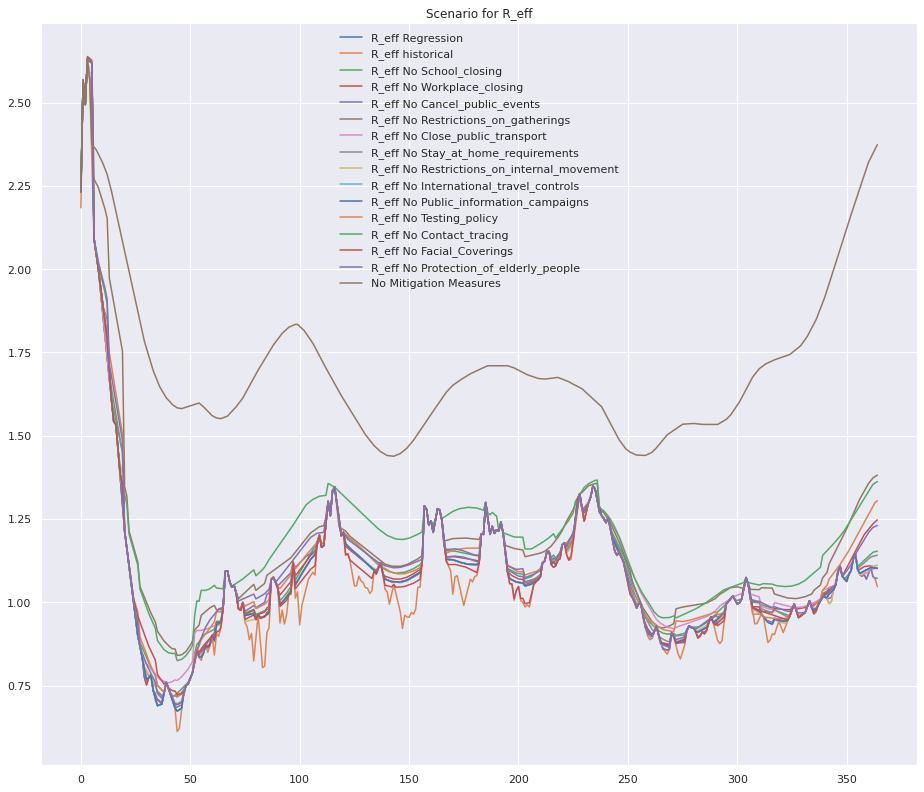

0.9347763790640148


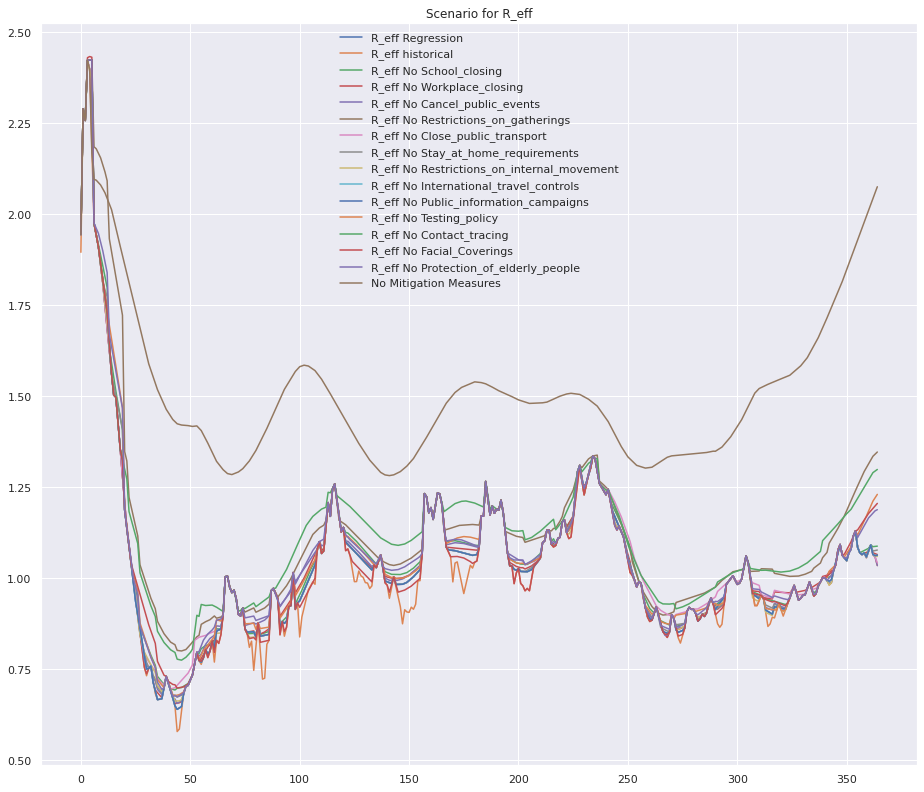

0.8469455747830679


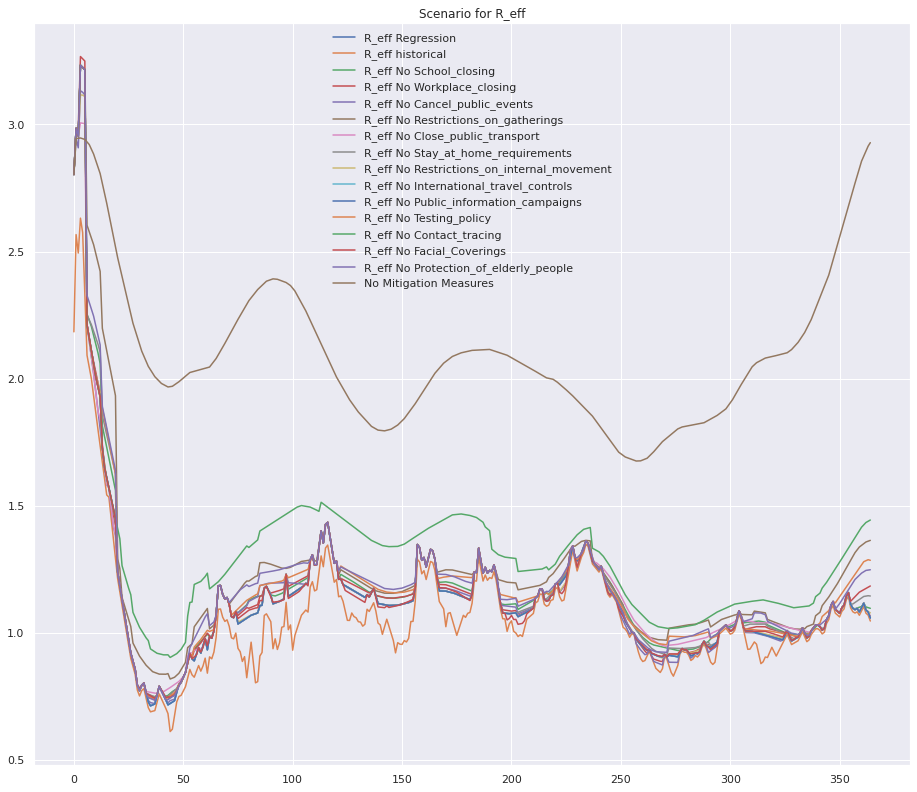

In [50]:
# Give MLP Regressor a shot
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from copy import deepcopy
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline

def postprocess(R_eff, R_pred):
    for i in range(len(R_pred)):
        R_pred[i] = R_pred[i] if R_pred[i] >= R_eff[i] else R_eff[i]
    return R_pred
        
        
batch_size=200
X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), y, random_state=1, test_size=0.3)
res = MLPRegressor(random_state=1, max_iter=1000, 
                   hidden_layer_sizes = (365, 365, 365, 365),
                   activation='relu', solver='adam',
                   learning_rate_init = 1e-3, shuffle=True,
                   tol=1e-6, early_stopping=True, validation_fraction=0.1,
                   batch_size=batch_size
                  ).fit(X_train, y_train)
print(res.score(X_test, y_test))
plt.plot(postprocess(y, res.predict(X)), label ='R_eff Regression')
plt.plot(y, label = 'R_eff historical')
X_orig = X.copy(deep=True)
for col in X_g.columns:
    if col not in irrelevant:
        X[col] = 0.0
        plt.plot(postprocess(y, res.predict(X)), 
                 label = "R_eff No {}".format(col))
        X = X_orig.copy(deep=True)
for col in X_g.columns:
    if col not in irrelevant:
        X[col] = 0.0
plt.plot(postprocess(y, res.predict(X)), label = 'No Mitigation Measures')
plt.title('Scenario for R_eff')
plt.legend()
plt.show()
X = X_orig.copy(deep=True) 

#Lets look at lowr and upr bounds
X_train, X_test, y_train, y_test = train_test_split(X, y_lwr, random_state=1, test_size=0.3)
res_lwr = MLPRegressor(random_state=1, max_iter=1000, 
                   hidden_layer_sizes = (365, 365, 365, 365),
                   activation='relu', solver='adam',
                   learning_rate_init = 1e-3, shuffle=True,
                   tol=1e-6, early_stopping=True, validation_fraction=0.1,
                   batch_size=batch_size
                  ).fit(X_train, y_train)
print(res_lwr.score(X_test, y_test))
plt.plot(postprocess(y_lwr, res_lwr.predict(X)), label ='R_eff Regression')
plt.plot(y_lwr, label = 'R_eff historical')
X_orig = X.copy(deep=True)
for col in X_g.columns:
    if col not in irrelevant:
        X[col] = 0.0
        plt.plot(postprocess(y_lwr, res_lwr.predict(X)), 
                 label = "R_eff No {}".format(col))
        X = X_orig.copy(deep=True)
for col in X_g.columns:
    if col not in irrelevant:
        X[col] = 0.0
plt.plot(postprocess(y_lwr, res_lwr.predict(X)), label = 'No Mitigation Measures')
plt.title('Scenario for R_eff')
plt.legend()
plt.show()
X = X_orig.copy(deep=True) 

X_train, X_test, y_train, y_test = train_test_split(X, y_upr, random_state=1, test_size=0.3)
res_upr = MLPRegressor(random_state=1, max_iter=1000, 
                   hidden_layer_sizes = (365, 365, 365, 365),
                   activation='relu', solver='adam',
                   learning_rate_init = 1e-3, shuffle=True,
                   tol=1e-6, early_stopping=True, validation_fraction=0.1,
                   batch_size=batch_size
                  ).fit(X_train, y_train)
print(res_upr.score(X_test, y_test))
plt.plot(postprocess(y_upr, res_upr.predict(X)), label ='R_eff Regression')
plt.plot(y, label = 'R_eff historical')
X_orig = X.copy(deep=True)
for col in X_g.columns:
    if col not in irrelevant:
        X[col] = 0.0
        plt.plot(postprocess(y_upr, res_upr.predict(X)), 
                 label = "R_eff No {}".format(col))
        X = X_orig.copy(deep=True)
for col in X_g.columns:
    if col not in irrelevant:
        X[col] = 0.0
plt.plot(postprocess(y_upr, res_upr.predict(X)), label = 'No Mitigation Measures')
plt.title('Scenario for R_eff')
plt.legend()
plt.show()
X = X_orig.copy(deep=True) 

## SEIR-FV Model with Reinfection, ICUs and Hospitalizations Capacities, Adjusted for Age-Groups and Virus Reproduction depending on Meteorological Effects and Government Policies
Improved SIR Model taking into account weather and effective reproduction number based on various mitigation scenarios

In [95]:
# SIR disease model
# Source: https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/
# https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Modellierung_Deutschland.pdf?__blob=publicationFile

# http://sherrytowers.com/2012/12/11/sir-model-with-age-classes/
# ICUs
# file:///tmp/mozilla_lorenz0/Austria%20Prognosis%20and%20actual%20COVID-19%20Diseased.pdf
# file:///tmp/mozilla_lorenz0/Austria%20Prognosis%20and%20actual%20COVID-19%20Diseased.pdf
#ICUs_free = 1072 # Mar 27 2020
#HOSPs_free = 21682 # Mar 27 2020

ICUs_free = aut_hosp_groups['FZICU']+aut_hosp_groups['FZICUFree']
ICUs_free = sum(ICUs_free)/len(ICUs_free
                              )
HOSPs_free = aut_hosp_groups['FZHosp']+aut_hosp_groups['FZHospFree']
HOSPs_free = sum(HOSPs_free)/len(HOSPs_free)

VAC_full_effect = 0.9 #Probability of any vaccine preventing contraction, cannot infect others
VAC_once_effect = 0.9 #Probability of any vaccine preventing death, can infect others

def deriv(t, y, N, gamma, delta, epsilon, rho, t_vac_once_start, t_vac_full_start, R_eff):
    #print(t, flush=True)
    ICUs_required = 0
    HOSPs_requried = 0
    N_sum = sum(N)
    numvars = 7
    
    #Compute ICUs and Hospital Beds required
    for i in range(0,len(y),numvars):
        S, E, I, R, F, V1, V2 = y[i:i+numvars]
        ICUs_required+=I*epsilon[i//numvars]*rho[i//numvars]
        HOSPs_requried+=I*epsilon[i//numvars]*rho[i//numvars]
    HOSPs_requried - ICUs_required
    
    # Hospital beds or ICUs full
    omega = float(ICUs_required > ICUs_free)
    kappa = float(HOSPs_requried > HOSPs_free)

    #Time until Exposed move to Infected
    alpha = 1.0/3.0 # https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Modellierung_Deutschland.pdf?__blob=publicationFile
    
    # Intra group contractions
    beta = [R_eff[int(round(t))]*(gamma[i]+delta_i) for i, delta_i in enumerate(delta)]
    
    # Inter group contractions
    #beta_avg = sum(beta)/len(beta)
    #beta = [0.5*(beta_avg+b) for b in beta]

    vacs_once_available = vac_once_per_day
    vacs_full_available = vac_full_per_day
    y_inv = y[::-1] # Invert for age prefering vaccinations
    y_i = ()
    for j in range(0,len(y_inv),numvars):
        S, E, I, R, F, V1, V2 = y_inv[j:j+numvars][::-1]
        i = len(y_inv)-numvars - j

        # Single and Double Vaccinations
        # Old First
        dV2dt = vacs_full_available if S > vacs_full_available else np.abs(vacs_full_available - S)
        if (dV2dt+V2) > (S+R+I+E+V1) or t < t_vac_full_start: # Sanity, can never vaccinated more than living gorup
            dV2dt = +0.0
        vacs_full_available = np.abs(vacs_full_available - dV2dt)
        
        dV1dt = vacs_once_available if S > vacs_once_available else np.abs(vacs_once_available - S)
        if (dV1dt+V1) > (S+R+I+E+V2) or t < t_vac_once_start: # Sanity, can never vaccinated more than living gorup
            dV1dt = +0.0
        vacs_once_available = np.abs(vacs_once_available - dV1dt)
        
        # Random
        #dV1dt = S * vac_once_per_day/N_sum*VAC_once_effect if t >= t_vac_once_start else 0
        #dV2dt = S * vac_full_per_day/N_sum*VAC_full_effect if t >= t_vac_full_start else 0
        
        
        # Decrease in Suspectables
        dSdt = -beta[i//numvars] * S * I / N[i//numvars] - dV2dt if S >= 0 else +0.0
            
        # Probability that and individual of a group has been succesfully vaccinated once
        theta = max(min(V1/S,1.0),0)
        
        # Suspectable to Exposed minus Exposed to Infected
        dEdt = beta[i//numvars] * S * I / N[i//numvars] - alpha * E
        
        # Infected to Recovered
        dRdt = (1+theta)* I * gamma[i//numvars] * (1 - (epsilon[i//numvars]*rho[i//numvars]*omega + rho[i//numvars]*kappa))
        
        # Infected to Fatalities
        dFdt = (1-theta)* I * delta[i//numvars] * (1 + (epsilon[i//numvars]*rho[i//numvars]*omega + rho[i//numvars]*kappa))
        
        # Exposed to Infected minus Recovered + Fatalities
        dIdt = alpha * E - dRdt - dFdt
        
        # Reinfection after reocivering possible after 5-7 months: 
        # EXPERIMENTAL
        # https://www.cell.com/immunity/fulltext/S1074-7613(20)30445-3
        # How ist it with Vaccines?
        dSdt += (1.0/180.0)*R + (1.0/210.0)*V2
        dV2dt += -(1.0/210.0)*V2
        dV1dt += -(1.0/210.0)*V1
        dRdt += -(1.0/180.0)*R
        
        
        y_i += dV2dt, dV1dt, dFdt, dRdt, dIdt, dEdt, dSdt
    return y_i[::-1]

from scipy.integrate import solve_ivp
def run_sim(N, E0, I0, R0, F0, V10, V20, gamma, delta, epsilon, rho, t, deriv, t_vac_once_start, t_vac_full_start, R):
    #Make y0:
    y0 = ()
    for n in N:
        S0 = n - E0- I0 - R0 - F0 - V20
        y0 += (S0, E0, I0, R0, F0, V10, V20)

    ret = solve_ivp(fun=deriv, t_span=(min(t), max(t)), y0=y0, t_eval=t, first_step = 0.01, max_step=0.25,
                    method='RK23', rtol=1e-1, atol=1e-1,
                    args=(N, gamma, delta, epsilon, rho, t_vac_once_start, t_vac_full_start, R))
    return [*ret['y']]

## NN Corrected SIR

SCENARIO: PREDICTED R, HISTORICAL MEASURES
Progress: 0.0%
[  -17   -15   -11   -10    -6    -1     5    19    26    55    78   106
   128   182   289   383   565   772   965  1177  1519  1884  2331  2823
  3353  3943  4561  5185  5835  6715  7280  7682  7963  8242  8398  8593
  8625  8547  8245  8060  7620  7359  7023  6678  6376  6160  5943  5701
  5281  4902  4534  4200  3987  3857  3530  3153  2954  2761  2568  2477
  2396  2263  2130  2011  1855  1777  1723  1671  1548  1474  1397  1311
  1190  1142  1098  1070  1019   993   969   981   942   942   946   936
   913   887   862   839   830   798   730   706   643   628   628   598
   585   533   547   514   555   562   560   529   514   510   502   514
   508   507   522   518   511   512   528   523   538   529   534   544
   555   605   617   657   669   738   801   838   925  1008  1056  1085
  1130  1202  1223  1266  1301  1306  1318  1327  1377  1407  1388  1408
  1440  1426  1434  1506  1531  1581  1606  1646  1584  1589  1572

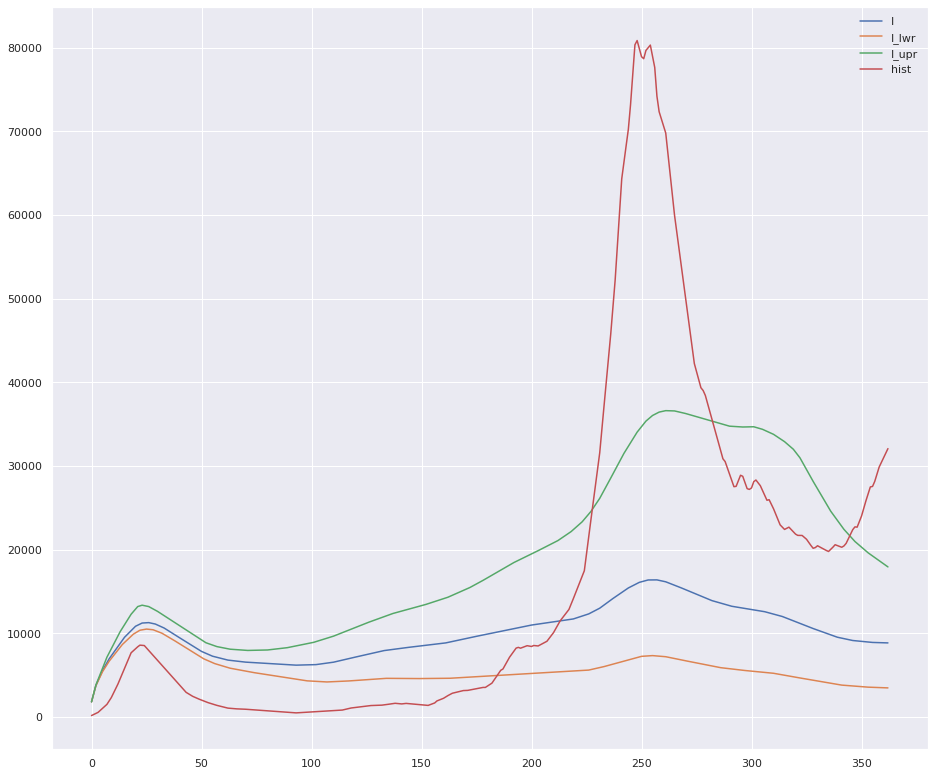

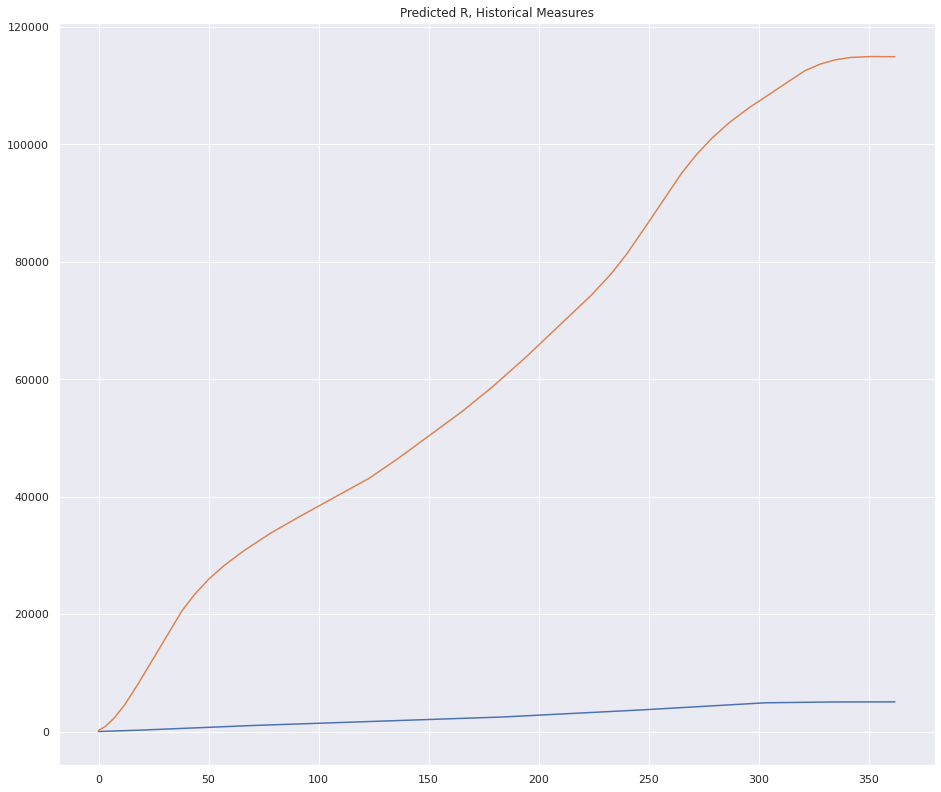

[363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363, 363]
Progress: 9.090909090909092%
Progress: 18.181818181818183%
Progress: 27.27272727272727%
Progress: 36.36363636363637%
Progress: 45.45454545454545%
Progress: 54.54545454545454%
Progress: 63.63636363636363%
Progress: 72.72727272727273%
Progress: 81.81818181818183%
Progress: 90.9090909090909%
Progress: 100.0%
10 9
SCENARIO RESULTS: PREDICTED R, HISTORICAL MEASURES
Infected: 357286 430291 503296
Fatal: 8128 8632 9136
Peak Hospitalization Requirements: 3331 3613 3894
Peak ICU Requirements: 430 589 749
[0.00000000e+00 7.94619181e-05 1.15662590e-04 1.81624464e-04
 4.56311318e-04 2.00592307e-03 9.42644123e-03 4.25610104e-02
 8.12852052e-02 1.36065249e-01]


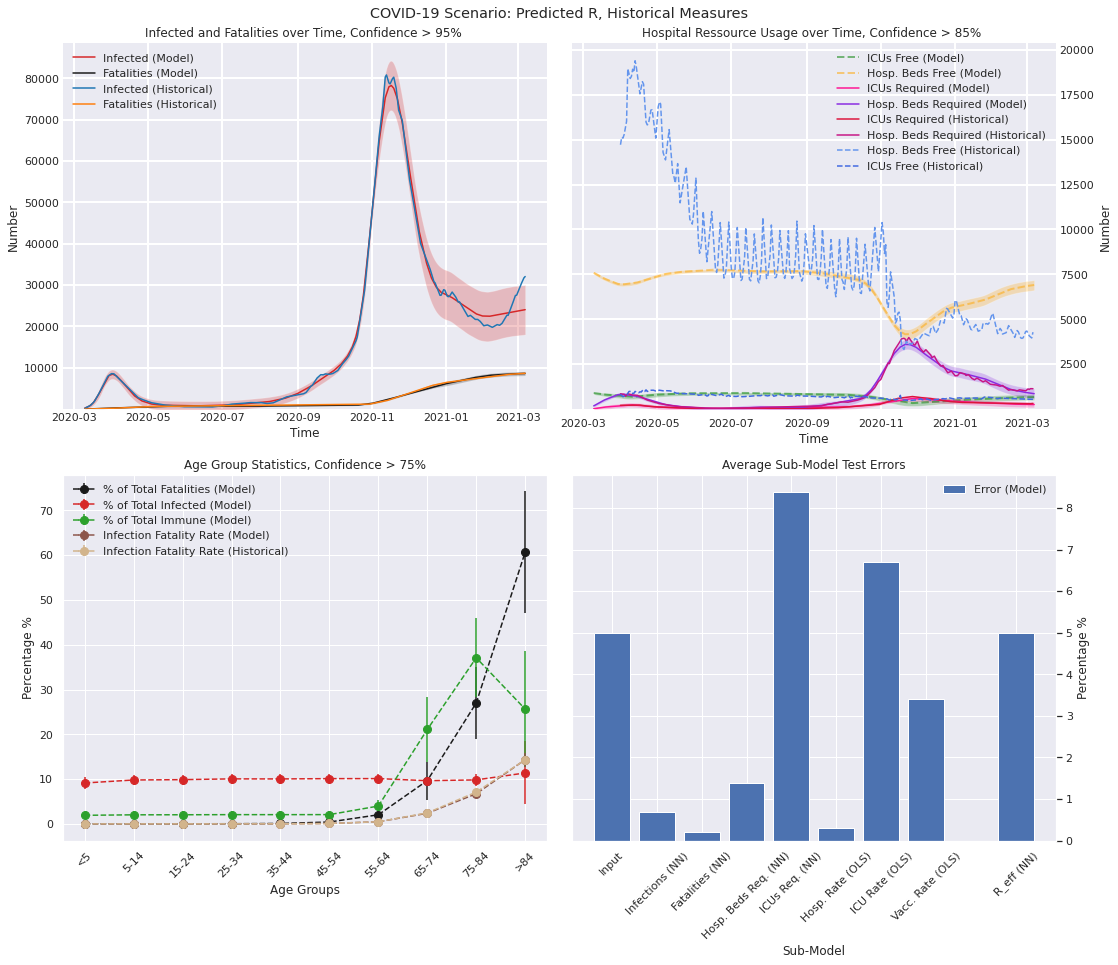

In [96]:
# Scenarios: Validate model with hisorical R data from 1 year of corona
# and compute what-if scenarios
# https://de.wikipedia.org/wiki/COVID-19-Pandemie_in_%C3%96sterreich#Ma%C3%9Fnahmen_im_Gesundheitsbereich
infected = aut_cov['Infected'].to_numpy()
fatal = aut_cov['Fatal'].to_numpy()
recovered = aut_cov['Recovered'].to_numpy()
t_vac_full_start = 317 #Full vaccinations 15.01.2021
t_vac_once_start = 298 #Full vaccinations 27.12.2020
duration = 363#len(aut_cov['Infected'].to_numpy())

scores = {'R2': r2_score,
          'EV': explained_variance_score,
          'RMSE': mean_squared_error,
          'RMSLE': mean_squared_log_error
         }


scenarios = {
    #'Historical R, Historical Measures' : [y_lwr, y, y_upr, scores],
    #
    'Predicted R, Historical Measures' : [
        #postprocess(y_lwr, res_lwr.predict(X)), 
        #postprocess(y, res.predict(X)), 
        #postprocess(y_upr, res_upr.predict(X)), 
        res_lwr.predict(X), 
        res.predict(X), 
        res_upr.predict(X), 
        scores],  
}
'''
X_orig = X.copy(deep=True)
for col in X_g.columns:
    if col not in irrelevant:
        X[col] = 0.0
        scenarios["No {}".format(col)] = [
            postprocess(y_lwr, res_lwr.predict(X)), 
            postprocess(y, res.predict(X)), 
            postprocess(y_upr, res_upr.predict(X)),  
            scores]
        X = X_orig.copy(deep=True)
    
    
for col in X_g.columns:
    if col not in irrelevant:
        X[col] = 0.0
scenarios["No Mitigation Measures"] = [
        postprocess(y_lwr, res_lwr.predict(X)), 
        postprocess(y, res.predict(X)), 
        postprocess(y_upr, res_upr.predict(X)),  
    scores]
X = X_orig.copy(deep=True)
'''
def is_fitted(model):
   # Source: https://stackoverflow.com/questions/39884009/whats-the-best-way-to-test-whether-an-sklearn-model-has-been-fitted/51200847
    attrs = [v for v in vars(model)
             if v.endswith("_") and not v.startswith("__")]
    
    return len(attrs) != 0


fitted =  False
topo = (duration, duration, duration, duration)
max_iter=1000
num_models = 10
score_threshold = 0.9
batch_size= 200
if fitted == False:
    res_infs = []
    res_fats = []
    res_hosps = []
    res_icus = []
    res_infs_r2 = []
    res_fats_r2 = []
    res_hosps_r2 = []
    res_icus_r2 = []
    for i in range(0,num_models):
        res_infs.append(MLPRegressor(max_iter=max_iter, 
                               hidden_layer_sizes = topo,
                               activation='relu', solver='adam',
                               learning_rate_init = 1e-3, shuffle=True,
                               tol=1e-6, early_stopping=True, validation_fraction=0.1,
                               batch_size=batch_size, warm_start= False, random_state = i
                              ))
        res_fats.append(MLPRegressor(max_iter=max_iter, 
                               hidden_layer_sizes = topo,
                               activation='relu', solver='adam',
                               learning_rate_init = 1e-3, shuffle=True,
                               tol=1e-6, early_stopping=True, validation_fraction=0.1,
                               batch_size=batch_size, warm_start= False, random_state = i
                              ))
        res_hosps.append(MLPRegressor(max_iter=max_iter, 
                               hidden_layer_sizes = topo,
                               activation='relu', solver='adam',
                               learning_rate_init = 1e-3, shuffle=True,
                               tol=1e-6, early_stopping=True, validation_fraction=0.1,
                               batch_size=batch_size//2, warm_start= False, random_state = i
                              ))
        res_icus.append(MLPRegressor(max_iter=max_iter, 
                               hidden_layer_sizes = topo,
                               activation='relu', solver='adam',
                               learning_rate_init = 1e-3, shuffle=True,
                               tol=1e-6, early_stopping=True, validation_fraction=0.1,
                               batch_size=batch_size//2, warm_start= False, random_state = i
                              ))


    
for scenario in scenarios:
    progress = 0.0
    print("SCENARIO: {}".format(scenario.upper()))
    print("Progress: {}%".format(progress))
    t = np.linspace(0, duration, duration).astype(int)
    
    R_eff_lwr = scenarios[scenario][0]
    R_eff = scenarios[scenario][1]
    R_eff_upr = scenarios[scenario][2]
    scoring = scenarios[scenario][3]
    
    print(infected)
    print(infected[4]*2.4 ,infected[4] , recovered[4], fatal[4])
    S0, E0, I0, R0, F0, V10, V20 = pop_groups, infected[13]*2.4 ,infected[13] , recovered[13], fatal[13], 0, 0 #205 Covid Cases March 10 2020
    delta = [x*(1./14) for x in pop_groups_ifr] #Death without Recovery after 14 Days
    gamma = [((1.-x)/15) for x in pop_groups_ifr] #Recovery without Death after 14 Days
    epsilon = pop_groups_hosp_icu # ICU Probability of
    rho = pop_groups_hosp #Hsopitalization Probability
    
    ret_lwr = run_sim(S0, E0, I0, R0, F0, V10, V20, gamma, delta, epsilon, rho, t, deriv, 
                  t_vac_once_start, t_vac_full_start, R_eff_lwr)
    ret = run_sim(S0, E0, I0, R0, F0, V10, V20, gamma, delta, epsilon, rho, t, deriv, 
                  t_vac_once_start, t_vac_full_start, R_eff)
    ret_upr = run_sim(S0, E0, I0, R0, F0, V10, V20, gamma, delta, epsilon, rho, t, deriv, 
                  t_vac_once_start, t_vac_full_start, R_eff_upr)
    
    S_upr, E_upr, I_upr, R_upr, F_upr, V1_upr, V2_upr = 0, 0, 0, 0, 0, 0, 0
    S, E, I, R, F, V1, V2 = 0, 0, 0, 0, 0, 0, 0
    S_lwr, E_lwr, I_lwr, R_lwr, F_lwr, V1_lwr, V2_lwr = 0, 0, 0, 0, 0, 0, 0
        
    # Summarize Results
    for i in range(0,len(ret_upr),7):
        S_lwr+=ret_lwr[i]
        E_lwr+=ret_lwr[i+1]
        I_lwr+=ret_lwr[i+2]
        R_lwr+=ret_lwr[i+3]
        F_lwr+=ret_lwr[i+4]
        V1_lwr+=ret_lwr[i+5]
        V2_lwr+=ret_lwr[i+6]
        
        S+=ret[i]
        E+=ret[i+1]
        I+=ret[i+2]
        R+=ret[i+3]
        F+=ret[i+4]
        V1+=ret[i+5]
        V2+=ret[i+6]
        
        S_upr+=ret_upr[i]
        E_upr+=ret_upr[i+1]
        I_upr+=ret_upr[i+2]
        R_upr+=ret_upr[i+3]
        F_upr+=ret_upr[i+4]
        V1_upr+=ret_upr[i+5]
        V2_upr+=ret_upr[i+6]
    
    #plt.plot(S, label='S')
    plt.plot(I, label='I')
    plt.plot(I_lwr, label='I_lwr')
    plt.plot(I_upr, label='I_upr')
    plt.plot(infected[13:363+13], label='hist')
    plt.legend()
    plt.show()
    plt.plot(F, label='F')
    plt.plot(R, label='R')
    plt.title(scenario)
    plt.show()
    
    print([len(l) for l in [I_upr, I, I_lwr, E_upr, E, E_lwr, R_upr, R, R_lwr, V2_upr, V2, V2_lwr]])
    # Extract Age Group Statistics:
    
    pct_fat_lwr, pct_fat, pct_fat_upr = [], [], []
    pct_inf_lwr, pct_inf, pct_inf_upr = [], [], []
    pct_ifr_lwr, pct_ifr, pct_ifr_upr = [], [], []
    pct_v_lwr, pct_v, pct_v_upr = [], [], []
    for i in range(0, aut_age_groups.shape[0], 1):
        pct_fat_lwr.append(ret_lwr[i*7+4][-1]/F_lwr[-1])
        pct_fat_upr.append(ret_upr[i*7+4][-1]/F_upr[-1])
        pct_fat.append(ret[i*7+4][-1]/F[-1])
        
        pct_inf_lwr.append((sum(ret_lwr[i*7+2])/14)/(sum(I_lwr)/14))
        pct_inf_upr.append((sum(ret_upr[i*7+2])/14)/(sum(I_upr)/14))
        pct_inf.append((sum(ret[i*7+2])/14)/(sum(I)/14))
        
        pct_ifr_lwr.append(ret_lwr[i*7+4][-1]/(sum(ret_lwr[i*7+2])/14))
        pct_ifr.append(ret[i*7+4][-1]/(sum(ret[i*7+2])/14))
        pct_ifr_upr.append(ret_upr[i*7+4][-1]/(sum(ret_upr[i*7+2])/14))
        
        pct_v_lwr.append(sum(ret_lwr[i*7+5]+ret_lwr[i*7+6]+ret_lwr[i*7+3])/(sum(V1_lwr)+sum(R_lwr)+sum(V2_lwr)))
        pct_v.append(sum(ret[i*7+5]+ret[i*7+6]+ret[i*7+3])/(sum(V1)+sum(R)+sum(V2)))
        pct_v_upr.append(sum(ret_upr[i*7+5]+ret_upr[i*7+6]+ret_upr[i*7+3])/(sum(V1_upr)+sum(R_upr)+sum(V2_upr)))
        
        # print(aut_age_groups['Altersgruppe'].iloc[i], 
        #      sum(ret[i*7+5]+ret[i*7+6]+ret[i*7+3])/(sum(V1)+sum(R)+sum(V2)))
              
                                       
        #print(aut_age_groups['Altersgruppe'].iloc[i],
        #      (sum(ret_lwr[i*7+2])/14)/(sum(I_lwr)/14),
        #      ret_lwr[i*7+4][-1]/F_lwr[-1])
        
        
    progress = 1.0/(num_models+1)
    print("Progress: {}%".format(progress*100))
    #d_inf = np.array([I_upr, I, I_lwr, E_upr, E, E_lwr, R_upr, R, R_lwr, V2_upr, V2, V2_lwr]).T
    #d_fat = np.array([F_upr, F, F_lwr, R_upr, R, R_lwr, V1_upr, V1, V1_lwr]).T
    d_inf = np.array([I_upr, I, I_lwr, E_upr, E, E_lwr, R_upr, R, R_lwr]).T
    d_fat = np.array([F_upr, F, F_lwr, R_upr, R, R_lwr]).T

    #scaler = MinMaxScaler()
    #d_inf = scaler.fit_transform(d_inf)
    #d_fat = scaler.fit_transform(d_fat)
    #from sklearn.preprocessing import normalize
    #d_inf = normalize(d_inf)
    #d_fat = normalize(d_fat)

    if scenario == 'Predicted R, Historical Measures' and fitted == False: 
            
        X_train_inf, X_test_inf, y_train_inf, y_test_inf = train_test_split(d_inf, 
                                                                            infected[13:363+13], 
                                                                            test_size=0.3)
        X_train_fat, X_test_fat, y_train_fat, y_test_fat = train_test_split(d_fat, 
                                                            fatal[13:363+13], 
                                                            test_size=0.3)
        X_train_hosp, X_test_hosp, y_train_hosp, y_test_hosp = train_test_split(d_inf[22:362], 
                                                            aut_hosp_groups['FZHosp'].to_numpy()[:340], 
                                                            test_size=0.3)
        X_train_icu, X_test_icu, y_train_icu, y_test_icu = train_test_split(d_inf[22:362], 
                                                            aut_hosp_groups['FZICU'].to_numpy()[:340], 
                                                            test_size=0.3)
        for i in range(0,num_models):
            if i < len(res_infs):
                res_infs[i].fit(X_train_inf, y_train_inf)
                score = res_infs[i].score(X_test_inf, y_test_inf)
                if score > score_threshold:
                    res_infs_r2.append(score)
                else:
                    del res_infs[i]
            
            if i < len(res_fats):
                res_fats[i].fit(X_train_fat, y_train_fat)
                score = res_fats[i].score(X_test_fat, y_test_fat)
                if score > score_threshold:
                    res_fats_r2.append(score)
                else:
                    del res_fats[i]
                
            if i < len(res_hosps):
                res_hosps[i].fit(X_train_hosp, y_train_hosp)
                score = res_hosps[i].score(X_test_hosp, y_test_hosp)
                if score > score_threshold:
                    res_hosps_r2.append(score)
                else:
                    del res_hosps[i]
            
            res_icus[i].fit(X_train_icu, y_train_icu)
            res_icus_r2.append(res_icus[i].score(X_test_icu, y_test_icu))
            progress = (2.0+i)/(num_models+1)
            print("Progress: {}%".format(progress*100))
        fitted = True
        print(len(res_infs), len(res_fats))
    else:
        progress = 100.0
        print("Progress: {}%".format(progress))
        
    infs, fats, hosps, icus = [], [], [], []
    for i in range(0,num_models):
        if i < len(res_infs) and is_fitted(res_infs[i]) and fitted:
            infs.append(res_infs[i].predict(d_inf))
        if i < len(res_fats) and is_fitted(res_fats[i]) and fitted:
            fats.append(res_fats[i].predict(d_fat))
        if i < len(res_hosps) and is_fitted(res_hosps[i]) and fitted:
            hosps.append(res_hosps[i].predict(d_inf))
        if i < len(res_icus) and is_fitted(res_icus[i]) and fitted:
            icus.append(res_icus[i].predict(d_inf))
    #for elem in infs:
    #    plt.plot(elem, label='infs')
    #    plt.show()
    
    z50, z75, z85, z90, z95, z97, z99 = 0.67449, 1.15035, 1.440, 1.64485, 1.95996, 2.17009, 3.29053
    input_err = 1.05 # Error of input data
    R_eff_est_err = 1.05 # Error of R_eff estimate
    hosp_est_err = 2.0-0.997 # Hospitalization rate estimation error
    icu_est_err = 2.0-0.933 # Hospitalization ICU rate estimation error
    vac1_err = 2.0-0.966 # Vaccinated once estimate error
    vac2_err = 2.0-0.966 # Vaccinated twice estimate error
    
    # Accumulated error of previous steps
    accumulated_err = input_err * R_eff_est_err * hosp_est_err * icu_est_err * vac1_err * vac2_err
    
    # NN Avg errors
    err_fats = 2.0 - sum(res_fats_r2)/len(res_fats_r2)
    err_infs = 2.0 - sum(res_infs_r2)/len(res_infs_r2)
    err_hosps = 2.0 - sum(res_hosps_r2)/len(res_hosps_r2)
    err_icus = 2.0 - sum(res_icus_r2)/len(res_icus_r2)

    inf_std = np.array(infs).std(axis=0)*accumulated_err*z95*err_infs
    inf_mean = np.array(infs).mean(axis=0)
    fat_std = np.array(fats).std(axis=0)*accumulated_err*z95*err_fats
    fat_mean = np.array(fats).mean(axis=0)
    hosp_std = np.array(hosps).std(axis=0)*accumulated_err*z85*err_hosps
    hosp_mean = np.array(hosps).mean(axis=0)
    icu_std = np.array(icus).std(axis=0)*accumulated_err*z85*err_icus
    icu_mean = np.array(icus).mean(axis=0)
    
    pct_inf_std = np.array([pct_inf,pct_inf_lwr,pct_inf_upr]).std(axis=0)*accumulated_err*z75*err_infs
    pct_inf_mean = np.array([pct_inf,pct_inf_lwr,pct_inf_upr]).mean(axis=0)
    pct_fat_std = np.array([pct_fat,pct_fat_lwr,pct_fat_upr]).std(axis=0)*accumulated_err*z75*err_fats
    pct_fat_mean = np.array([pct_fat,pct_fat_lwr,pct_fat_upr]).mean(axis=0)
    
    pct_ifr_std = np.array([pct_ifr,pct_ifr_lwr,pct_ifr_upr]).std(axis=0)*accumulated_err*z75*err_fats*err_infs
    pct_ifr_mean = np.array([pct_ifr,pct_ifr_lwr,pct_ifr_upr]).mean(axis=0)
    
    pct_v_std = np.array([pct_v,pct_v_lwr,pct_v_upr]).std(axis=0)*accumulated_err*z75*err_fats*err_infs
    pct_v_mean = np.array([pct_v,pct_v_lwr,pct_v_upr]).mean(axis=0)

    # Correct 'rising dead' problem', not even 25 Pfizer shots can do that...
    # Dissallow decrease of uncertainity
    # Cap max free hosp, ICU ressources.

    for i in range(1, fat_mean.shape[0]):
        if fat_mean[i] < fat_mean[i-1]:
            fat_mean[i] = fat_mean[i-1]
            
        if inf_std[i] < inf_std[i-1]:
            inf_std[i] = inf_std[i-1]
            
        if fat_std[i] < fat_std[i-1]:
            fat_std[i] = fat_std[i-1]
    
        if icu_std[i] < icu_std[i-1]:
            icu_std[i] = icu_std[i-1]
            
        if hosp_std[i] < hosp_std[i-1]:
            hosp_std[i] = hosp_std[i-1]

    hosp_free = [HOSPs_free]*len(F_lwr) - hosp_mean
    hosp_free_upr = [HOSPs_free]*len(F_lwr) - hosp_mean+hosp_std
    for i in range(0, hosp_free.shape[0]):
        if hosp_free_upr[i] > HOSPs_free:
            hosp_free_upr[i] = HOSPs_free
        if hosp_free[i] > HOSPs_free:
            hosp_free[i] = HOSPs_free
            
    icu_free = [ICUs_free]*len(F_lwr) - icu_mean
    icu_free_upr = [ICUs_free]*len(F_lwr) - icu_mean+icu_std
    for i in range(0, hosp_free.shape[0]):
        if icu_free_upr[i] > ICUs_free:
            icu_free_upr[i] = ICUs_free
        if icu_free[i] > ICUs_free:
            icu_free[i] = ICUs_free
    
    
    # Print Results
    print("SCENARIO RESULTS: {}".format(scenario.upper()))
    print('Infected:', 
          int(sum(inf_mean-inf_std)/14), 
          int(sum(inf_mean)/14), 
          int(sum(inf_mean+inf_std)/14))
    print('Fatal:', 
          int(np.amax(fat_mean-fat_std)), 
          int(np.amax(fat_mean)), 
          int(np.amax(fat_mean+fat_std)))
    print('Peak Hospitalization Requirements:', 
          int(np.amax(hosp_mean-hosp_std)), 
          int(np.amax(hosp_mean)), 
          int(np.amax(hosp_mean+hosp_std)))
    print('Peak ICU Requirements:', 
          int(np.amax(icu_mean-icu_std)), 
          int(np.amax(icu_mean)), 
          int(np.amax(icu_mean+icu_std)))
    #print(#pct_lwr*int(sum(inf_mean-inf_std)/14), 
    #      #pct*int(sum(inf_mean-inf_std)/14),
    #      pct_upr*int(sum(inf_mean-inf_std)/14))

    
    # Visualize Pandemic Curve
    sns.set(rc={'figure.figsize':(15.7*1.0,10.27*1.33)})
    base = datetime.datetime(2020, 3, 10, 00, 00)
    t = [base + datetime.timedelta(days=x) for x in range(duration)]
    fig, ((ax, ax2), (ax3, ax4)) = plt.subplots(2, 2)
    ax.yaxis.set_major_locator(ticker.MaxNLocator(10))
    ax.fill_between(t, inf_mean-inf_std, inf_mean+inf_std, facecolor='tab:red', alpha=0.25, interpolate=True)
    ax.plot(t, inf_mean, 'tab:red', label='Infected (Model)')
    ax.fill_between(t, fat_mean-fat_std, fat_mean+fat_std, facecolor='k', alpha=0.25, interpolate=True)
    ax.plot(t, fat_mean, 'k', label='Fatalities (Model)')
    
    if scenario == 'Predicted R, Historical Measures' or scenario == 'Historical R, Historical Measures':
        ax.plot(t, infected[13:363+13], 'tab:blue', label='Infected (Historical)')
        ax.plot(t, fatal[13:363+13], 'tab:orange', label='Fatalities (Historical)')
    
    ax.set_xlabel('Time')
    ax.set_ylabel('Number')
    ax.set_ylim(1.0)
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend(loc='upper left')
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    ax.set_title("Infected and Fatalities over Time, Confidence > 95% ")
    fig.tight_layout()  

    # Visualize Hospital Ressoruces
    ax2.yaxis.set_major_locator(ticker.MaxNLocator(10))
    ax2.set_ylabel('Number')
    ax2.plot(t, icu_free,'green', alpha=0.5, lw=2, 
             label='ICUs Free (Model)', linestyle='dashed')
    ax2.fill_between(t, 
                     icu_free-icu_std, 
                     icu_free_upr,
                     facecolor='green', alpha=0.25, interpolate=True)
                     
    ax2.plot(t, hosp_free, 'orange', alpha=0.5, lw=2, 
             label='Hosp. Beds Free (Model)', linestyle='dashed')
    ax2.fill_between(t, 
                     hosp_free-hosp_std, 
                     hosp_free_upr,
                     facecolor='orange', alpha=0.25, interpolate=True)
                     
    ax2.fill_between(t, 
                     icu_mean-icu_std, 
                     icu_mean+icu_std, 
                     facecolor='deeppink', alpha=0.25, interpolate=True)
    ax2.plot(t, icu_mean, 'deeppink', 
           label='ICUs Required (Model)')
    ax2.fill_between(t, 
                     hosp_mean-hosp_std, 
                     hosp_mean+hosp_std,
                     facecolor='blueviolet', alpha=0.25, interpolate=True)               
    ax2.plot(t, hosp_mean, 'blueviolet', 
           label='Hosp. Beds Required (Model)')
    
    if scenario == 'Predicted R, Historical Measures' or scenario == 'Historical R, Historical Measures':
        ax2.plot(t[22:362], 
               aut_hosp_groups['FZICU'].to_numpy()[:340], 'crimson', 
               label='ICUs Required (Historical)')
        ax2.plot(t[22:362], 
               aut_hosp_groups['FZHosp'].to_numpy()[:340], 'mediumvioletred', 
               label='Hosp. Beds Required (Historical)')
        ax2.plot(t[22:362], 
               aut_hosp_groups['FZHospFree'].to_numpy()[:340], 'cornflowerblue', 
               label='Hosp. Beds Free (Historical)', linestyle='dashed')
        ax2.plot(t[22:362], 
               aut_hosp_groups['FZICUFree'].to_numpy()[:340], 'royalblue', 
               label='ICUs Free (Historical)', linestyle='dashed')
    
    ax2.tick_params(axis='y')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Number')
    ax2.set_ylim(1.0)
    ax2.yaxis.set_tick_params(length=0)
    ax2.yaxis.set_label_position("right")
    ax2.yaxis.tick_right()
    ax2.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax2.legend(loc='upper right')
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax2.spines[spine].set_visible(False)
    ax2.set_title("Hospital Ressource Usage over Time, Confidence > 85% ")
    
    # Visualize age group stats: TODO: Probably we should add SIR error here
    ax3.set_xlabel('Age Groups')
    ax3.set_ylabel('Percentage %')
    ax3.set_title('Age Group Statistics, Confidence > 75%')
    print(pct_fat_std)
    ax3.errorbar(x=np.linspace(1,len(pct_fat_mean), len(pct_fat_mean)).astype(int), 
            y=pct_fat_mean.T*100,
            xerr=0.0, yerr=pct_fat_std*100,
            marker='o', markersize=8, color='k', 
            ls =  '--', label='% of Total Fatalities (Model)')
    
    ax3.errorbar(x=np.linspace(1,len(pct_inf_mean), len(pct_inf_mean)).astype(int), 
            y=pct_inf_mean.T*100,
            xerr=0.0, yerr=pct_inf_std*100,
            marker='o', markersize=8, color='tab:red', 
            ls =  '--', label='% of Total Infected (Model)')
    
    ax3.errorbar(x=np.linspace(1,len(pct_v_mean), len(pct_v_mean)).astype(int), 
            y=pct_v_mean.T*100,
            xerr=0.0, yerr=pct_v_std*100,
            marker='o', markersize=8, color='tab:green', 
            ls =  '--', label='% of Total Immune (Model)')
    
    ax3.errorbar(x=np.linspace(1,len(pct_ifr_mean), len(pct_ifr_mean)).astype(int), 
            y=pct_ifr_mean.T*100,
            xerr=0.0, yerr=pct_ifr_std*100,
            marker='o', markersize=8, color='tab:brown', 
            ls =  '--', label='Infection Fatality Rate (Model)')
    
    if scenario == 'Predicted R, Historical Measures' or scenario == 'Historical R, Historical Measures':
        ax3.errorbar(x=np.linspace(1,len(aut_age_groups['IFR']), len(aut_age_groups['IFR'])).astype(int), 
                y=aut_age_groups['IFR'].T*100,
                xerr=0.0, yerr=0.0,
                marker='o', markersize=8, color='tan', 
                ls =  '--', label='Infection Fatality Rate (Historical)')
    
    ax3.set_xticks(np.linspace(1,len(pct_inf), len(pct_inf)).astype(int))
    ax3.set_xticklabels([label[0] for label in aut_age_groups['Altersgruppe']])
    for tick in ax3.get_xticklabels():
        tick.set_rotation(45)
    legend = ax3.legend(loc='upper left')
    legend.get_frame().set_alpha(0.5)
    
    
    # Visualize Model Intrinsic and Data Errors
    if scenario == 'Predicted R, Historical Measures' or scenario == 'Historical R, Historical Measures':
        errs = np.array([input_err-1.0, err_infs-1.0, err_fats-1.0, err_hosps-1.0, 
                err_icus-1.0, hosp_est_err-1.0, icu_est_err-1.0, (vac1_err + vac2_err)*0.5-1.0,
                R_eff_est_err-1.0
        ])*100
        err_labels = ['Input', 'Infections (NN)', 'Fatalities (NN)', 'Hosp. Beds Req. (NN)', 
                      'ICUs Req. (NN)', 'Hosp. Rate (OLS)', 'ICU Rate (OLS)', 'Vacc. Rate (OLS)', 'R_eff (NN)'
                     ]
        ax4.set_ylabel('Percentage %')
        ax4.set_title('Average Sub-Model Test Errors')
        ax4.set_xlabel('Error Source')
    else:
        errs = np.array([err_infs*(sum(inf_std)/len(inf_std)), err_fats*(sum(fat_std)/len(fat_std)), 
                         err_hosps*(sum(hosp_std)/len(hosp_std)), err_icus*(sum(icu_std)/len(icu_std))  
        ])*accumulated_err
        err_labels = ['Infections (NN)', 'Fatalities (NN)', 'Hosp. Beds Req. (NN)', 'ICUs Req. (NN)'
                     ]
        ax4.set_ylabel('Number')
        ax4.set_title('Scenario Specific Average Absolute Sub-Model Errors')
        ax4.set_xlabel('Sub-Model')
    
    
    ax4.set_xlabel('Sub-Model')
    ax4.yaxis.set_label_position("right")
    ax4.yaxis.tick_right()

    ax4.bar(x=np.linspace(0,len(errs), len(errs)).astype(int), 
            height=errs,
            label='Error (Model)')
    
    
    ax4.set_xticks(np.linspace(0,len(errs), len(errs)).astype(int))
    ax4.set_xticklabels(err_labels)
    for tick in ax4.get_xticklabels():
        tick.set_rotation(45)

    legend = ax4.legend(loc='upper right')
    legend.get_frame().set_alpha(0.5)
    
    fig.suptitle("COVID-19 Scenario: {}".format(scenario))
    fig.tight_layout()  
    fig.savefig(scenario)
    plt.show()
    # Done 100%: Seperate Ages Groups based on Output of SIR model proportionlly
    # TODO: Infer recovered, vaccinated, and so on
    # Done 50%: fix hospital requirements

            FZHosp  FZHospFree  FZICU  FZICUFree
Meldedat                                        
01.04.2020     856       14713    215        828
02.04.2020     823       15131    219        747
03.04.2020     829       15079    245        695
04.04.2020     826       15276    245        724
05.04.2020     712       15740    244        768
...            ...         ...    ...        ...
28.06.2021     118        1948     61        804
29.06.2021     129        1933     56        787
30.06.2021     112        1946     60        769
01.07.2021     112        2043     53        770
02.07.2021     101        1934     49        783

[458 rows x 4 columns]
927.6353711790393
7770.410480349345


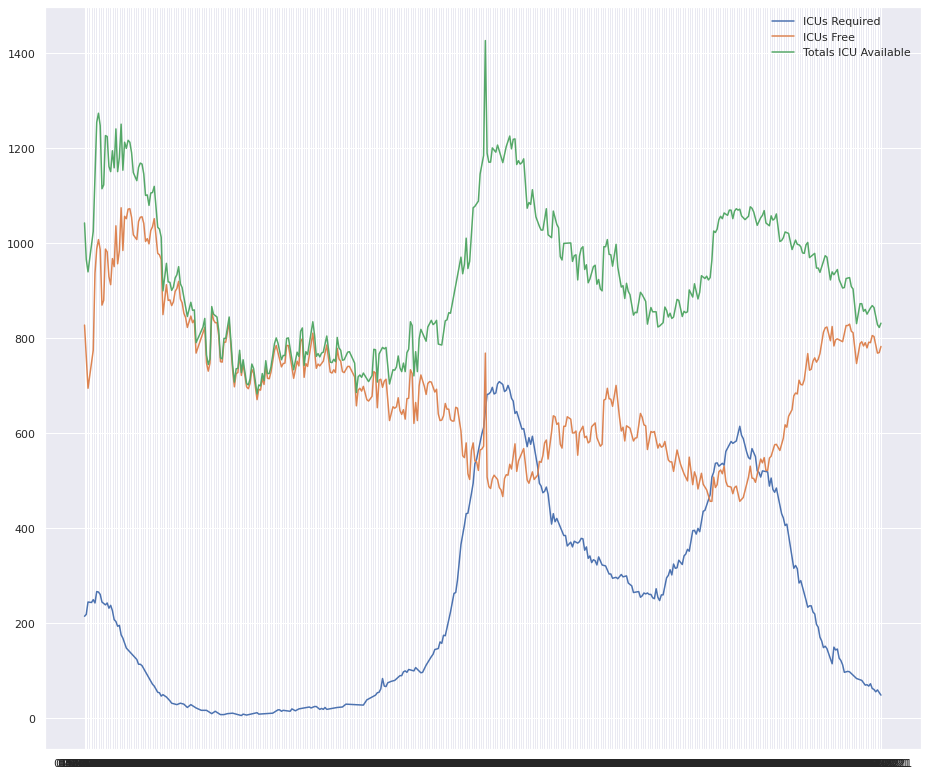

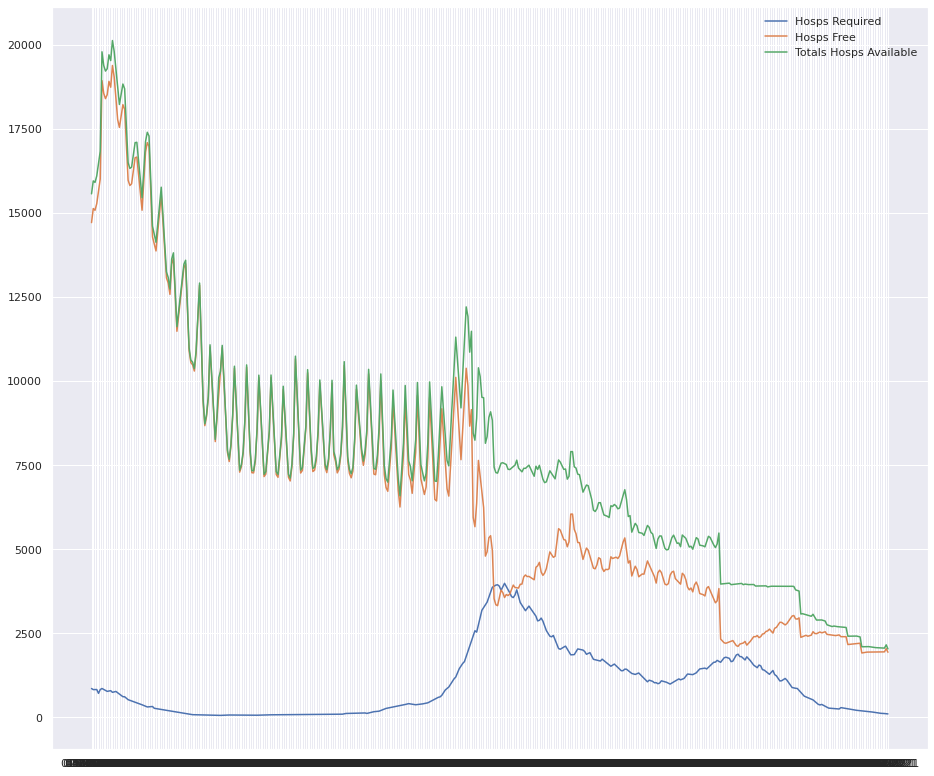

In [97]:
#print(max(aut_hosp_groups['FZICU']))
#print(max(aut_hosp_groups['FZHosp']))
#print(aut_hosp_groups['FZHosp'])
#print(aut_hosp_groups['FZHosp'].shape)
print(aut_hosp_groups)
asd = aut_hosp_groups['FZICU']+aut_hosp_groups['FZICUFree']
print(sum(asd)/len(asd))
asd = aut_hosp_groups['FZHosp']+aut_hosp_groups['FZHospFree']
print(sum(asd)/len(asd))

plt.plot(aut_hosp_groups['FZICU'], label='ICUs Required')
plt.plot(aut_hosp_groups['FZICUFree'], label='ICUs Free')
plt.plot(aut_hosp_groups['FZICU']+aut_hosp_groups['FZICUFree'], label='Totals ICU Available')
plt.legend()
plt.show()

plt.plot(aut_hosp_groups['FZHosp'], label='Hosps Required')
plt.plot(aut_hosp_groups['FZHospFree'], label='Hosps Free')
plt.plot(aut_hosp_groups['FZHosp']+aut_hosp_groups['FZHospFree'], label='Totals Hosps Available')
plt.legend()
plt.show()

In [98]:
x = ('11', '21', '31', '12', '22', '32', '13', '23', '33')

for i in range(0, 10, 1):
    print(x)
    x_new = ()
    x_inv = x[::-1]
    print(i)
    for j in range(0, len(x), 3):
        a, b, c = x_inv[j:j+3][::-1]
        print(a,b,c)
        x_new += c, b, a
    #print(x) 
    x = x_new[::-1]


('11', '21', '31', '12', '22', '32', '13', '23', '33')
0
13 23 33
12 22 32
11 21 31
('11', '21', '31', '12', '22', '32', '13', '23', '33')
1
13 23 33
12 22 32
11 21 31
('11', '21', '31', '12', '22', '32', '13', '23', '33')
2
13 23 33
12 22 32
11 21 31
('11', '21', '31', '12', '22', '32', '13', '23', '33')
3
13 23 33
12 22 32
11 21 31
('11', '21', '31', '12', '22', '32', '13', '23', '33')
4
13 23 33
12 22 32
11 21 31
('11', '21', '31', '12', '22', '32', '13', '23', '33')
5
13 23 33
12 22 32
11 21 31
('11', '21', '31', '12', '22', '32', '13', '23', '33')
6
13 23 33
12 22 32
11 21 31
('11', '21', '31', '12', '22', '32', '13', '23', '33')
7
13 23 33
12 22 32
11 21 31
('11', '21', '31', '12', '22', '32', '13', '23', '33')
8
13 23 33
12 22 32
11 21 31
('11', '21', '31', '12', '22', '32', '13', '23', '33')
9
13 23 33
12 22 32
11 21 31


In [211]:
oxgrt2 = oxgrt.loc[oxgrt['CountryName'] == 'Austria']
oxgrt2 = oxgrt2[cols].iloc[69:]
oxgrt2.reset_index(inplace=True, drop=True)
oxgrt2 = oxgrt2.fillna(method="pad")
X_g_new = oxgrt2[oxgrt2.columns[:20]]
#X_g_new.columns = [''.join(col.split('_')[1:]).replace(' ', '_').replace('/', '_') for col in X_g.columns]
X_g_new.head()
print(X_g_new.shape)
#plt.plot(X_g_new['StringencyIndex'][10:30])

(439, 20)


Int64Index([195501, 195502, 195503, 195504, 195505, 195506, 195507, 195508,
            195509, 195510,
            ...
            202005, 202006, 202007, 202008, 202009, 202010, 202011, 202012,
            202101, 202102],
           dtype='int64', name='REF_DATE', length=794)
Index(['T', 'T_MAX', 'T_MIN', 'MEAN_T_MAX', 'MEAN_T_MIN', 'NUM_FROST',
       'NUM_ICE', 'NUM_SUMMER', 'NUM_HEAT', 'P', 'P_MAX', 'P_MIN', 'SUN_H',
       'NUM_CLEAR', 'NUM_CLOUD', 'REL_HUM', 'REL_HUM_MAX', 'REL_HUM_MIN',
       'WIND_VEL', 'NUM_WIND_VEL60', 'WIND_VEL_MAX', 'PRECP_SUM',
       'NUM_PRECP_01'],
      dtype='object')
Index(['School_closing', 'Workplace_closing', 'Cancel_public_events',
       'Restrictions_on_gatherings', 'Close_public_transport',
       'Stay_at_home_requirements', 'Restrictions_on_internal_movement',
       'International_travel_controls', 'Income_support',
       'Debt_contract_relief', 'Fiscal_measures', 'International_support',
       'Public_information_campaigns', 'Testing_

No handles with labels found to put in legend.


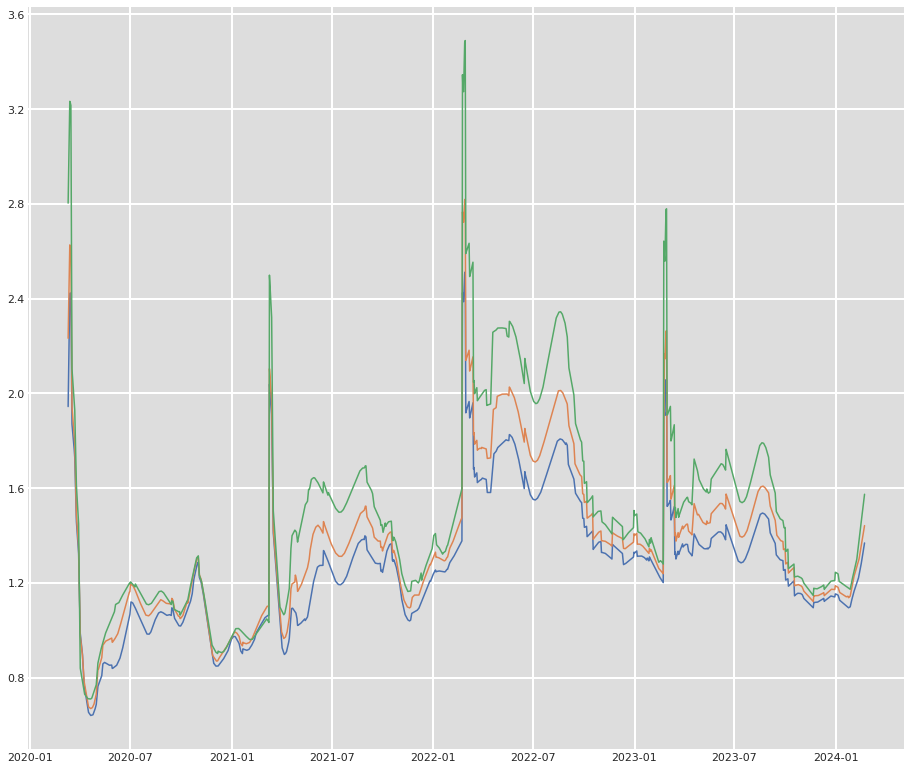

In [231]:
# Make a simple statistical weather prediction neglecting global warming, etc 
import random
aut_weather[aut_weather.columns[5:28]] = aut_weather[aut_weather.columns[5:28]].replace({',' : '.'}, regex=True).astype(float)
print(aut_weather.index[:782+12]) #which rows to select for data since march 1 2020
print(aut_weather.columns[5:28])
X_w_all = aut_weather[aut_weather.columns[5:28]].iloc[:782+12]#.to_numpy()

# Slow and ugly but does the job
X_w_all_agg = pd.DataFrame()
for col in X_w_all.columns:
    month_mean = []
    month_std = []
    for j in range(0,12,1):
        year = []
        for i in range(j+12*40, len(X_w_all[col]),12):
            year.append(X_w_all[col].iloc[i])
        month_mean.append(np.array(year).mean())
        month_std.append(np.array(year).std())
    X_w_all_agg["{}_mean".format(col)] = month_mean
    X_w_all_agg["{}_std".format(col)] = month_std

X_w_all_new_1 = pd.DataFrame()
X_w_all_new_2 = pd.DataFrame()
X_w_all_new_3 = pd.DataFrame()


for col in X_w_all.columns:
    X_w_all_new_1[col] = (
        X_w_all_agg["{}_mean".format(col)]+X_w_all_agg["{}_std".format(col)]*random.uniform(-2.0,2.0)
    )
    X_w_all_new_2[col] = (
        X_w_all_agg["{}_mean".format(col)]+X_w_all_agg["{}_std".format(col)]*random.uniform(-2.0,2.0)
    )
    X_w_all_new_3[col] = (
        X_w_all_agg["{}_mean".format(col)]+X_w_all_agg["{}_std".format(col)]*random.uniform(-2.0,2.0)
    )
    
'''
for col in X_w_all.columns:
    X_w_all_new_1[col] = (
        X_w_all_agg["{}_mean".format(col)]+X_w_all_agg["{}_std".format(col)].apply(
            lambda x:x*random.uniform(-1.0,1.0)
        )
    )
    X_w_all_new_2[col] = (
        X_w_all_agg["{}_mean".format(col)]+X_w_all_agg["{}_std".format(col)].apply(
            lambda x:x*random.uniform(-1.0,1.0)
        )
    )
    X_w_all_new_3[col] = (
        X_w_all_agg["{}_mean".format(col)]+X_w_all_agg["{}_std".format(col)].apply(
            lambda x:x*random.uniform(-1.0,1.0)
        )
    )
'''    
X_w_hist = aut_weather[aut_weather.columns[5:28]].iloc[782:782+12]
X_w_1yr = pd.concat((X_w_hist, X_w_all_new_1)).reset_index(drop=True)
X_w_2yr = pd.concat((X_w_hist, X_w_all_new_1, X_w_all_new_2)).reset_index(drop=True)
X_w_3yr = pd.concat((X_w_hist, X_w_all_new_1, X_w_all_new_2, X_w_all_new_3)).reset_index(drop=True)

X_w_1yr = pd.DataFrame(
    signal.resample(X_w_1yr, np.linspace(0,365*2,365*2).shape[0]),
    columns = X_w_1yr.columns)
#plt.plot(X_w_1yr['T'])
#plt.show()

X_w_2yr = pd.DataFrame(
    signal.resample(X_w_2yr, np.linspace(0,365*3,365*3).shape[0]),
    columns = X_w_2yr.columns)
#plt.plot(X_w_2yr['T'])
#plt.show()

X_w_3yr = pd.DataFrame(
    signal.resample(X_w_3yr, np.linspace(0,365*4,365*4).shape[0]),
    columns = X_w_3yr.columns)
#plt.plot(X_w_3yr['T'])
#plt.show()


# Get 2, 3 yrs of goverment measures
print(X_g.columns)

X_g_2yr = pd.concat((X_g, X_g, X_g)) #just repeat 2020

X_g_3yr = pd.concat((X_g, X_g, X_g, X_g)) #just repeat 2020

# Get best weather features
X_w_2yr = X_w_2yr[features]
X_w_3yr = X_w_3yr[features]

#Engineer features for prediction of Reproduction:
kernlen=2
nsig=1
k = np.linspace(-nsig, nsig, kernlen+1)
kern1d = np.diff(st.norm.cdf(k))
pd.options.mode.chained_assignment = None 
print(X_w_2yr.columns)
for col in X_w_2yr.columns:
    X_w_2yr["{}_log+1".format(col)] = (X_w_2yr[col]+1).transform(np.log) # Log transform
    X_w_2yr["{}_conv".format(col)] = np.convolve(X_w_2yr[col], kern1d, 'same') # Convolution
    X_w_2yr["{}_pow2".format(col)] = X_w_2yr[col]*X_w_2yr[col] # Power transform
pd.options.mode.chained_assignment = 'warn' 

pd.options.mode.chained_assignment = None 
print(X_w_3yr.columns)
for col in X_w_3yr.columns:
    X_w_3yr["{}_log+1".format(col)] = (X_w_3yr[col]+1).transform(np.log) # Log transform
    X_w_3yr["{}_conv".format(col)] = np.convolve(X_w_3yr[col], kern1d, 'same') # Convolution
    X_w_3yr["{}_pow2".format(col)] = X_w_3yr[col]*X_w_3yr[col] # Power transform
pd.options.mode.chained_assignment = 'warn' 

scaler = MinMaxScaler()
X_g_2yr = pd.DataFrame(scaler.fit_transform(X_g_2yr), columns=X_g_2yr.columns)
X_g_3yr = pd.DataFrame(scaler.fit_transform(X_g_3yr), columns=X_g_3yr.columns)
X_2yr = pd.concat((X_w_2yr, X_g_2yr), axis=1).reset_index(drop=True)
X_3yr = pd.concat((X_w_3yr, X_g_3yr), axis=1).reset_index(drop=True)
#X_2yr = X_2yr.drop(columns=insignificant)
#X_3yr = X_3yr.drop(columns=insignificant)

X_2yr =  pd.DataFrame(scaler.fit_transform(X_2yr.fillna(method="ffill")), columns=X_2yr.columns)
X_3yr =  pd.DataFrame(scaler.fit_transform(X_3yr.fillna(method="ffill")), columns=X_3yr.columns)

#X_3yr = signal.resample(X_3yr, np.linspace(0,365*4,365*4).shape[0]),

#print(X_3yr, X_2yr)
from scipy.ndimage import gaussian_filter

X_2yr = pd.DataFrame(gaussian_filter(X_2yr.iloc[15: , :], sigma=0.15), columns=X_2yr.columns)
X_3yr = pd.concat((X_orig, X_2yr[X_orig.columns]), axis=0).reset_index(drop=True)


base = datetime.datetime(2020, 3, 10, 00, 00)
t = [base + datetime.timedelta(days=x) for x in range(X_3yr.shape[0])]
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.yaxis.set_major_locator(ticker.MaxNLocator(10))
#plt.plot(res_lwr.predict(X_3yr))
ax.plot(t, res_lwr.predict(X_3yr))
ax.plot(t, res.predict(X_3yr))
ax.plot(t, res_upr.predict(X_3yr))
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)

SCENARIO: PREDICTED R, HISTORICAL MEASURES
Progress: 0.0%


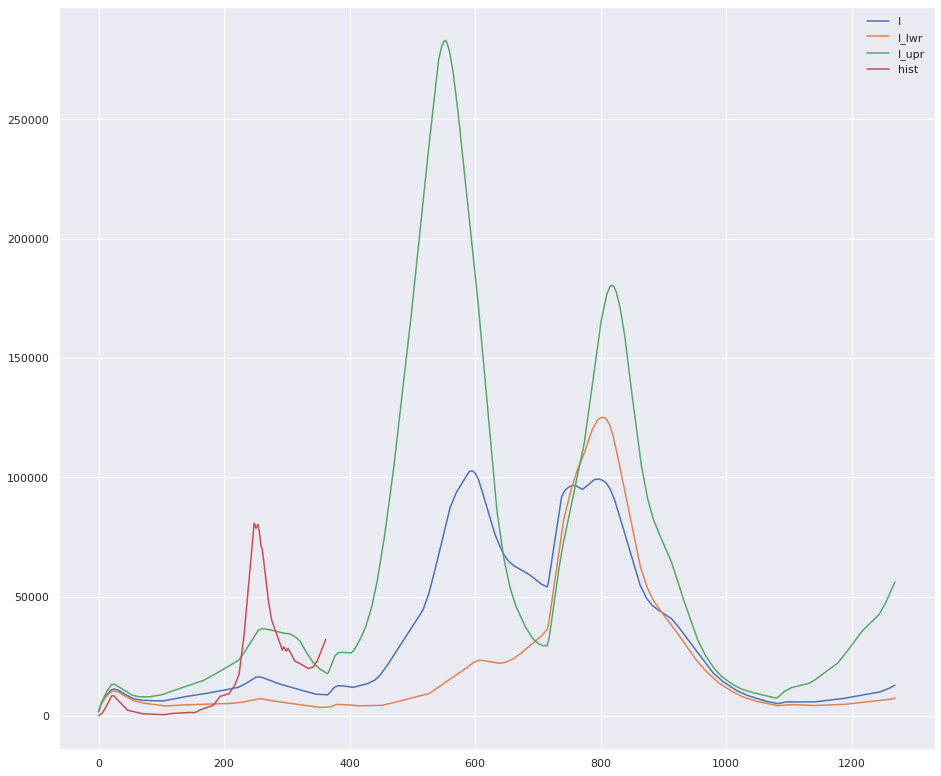

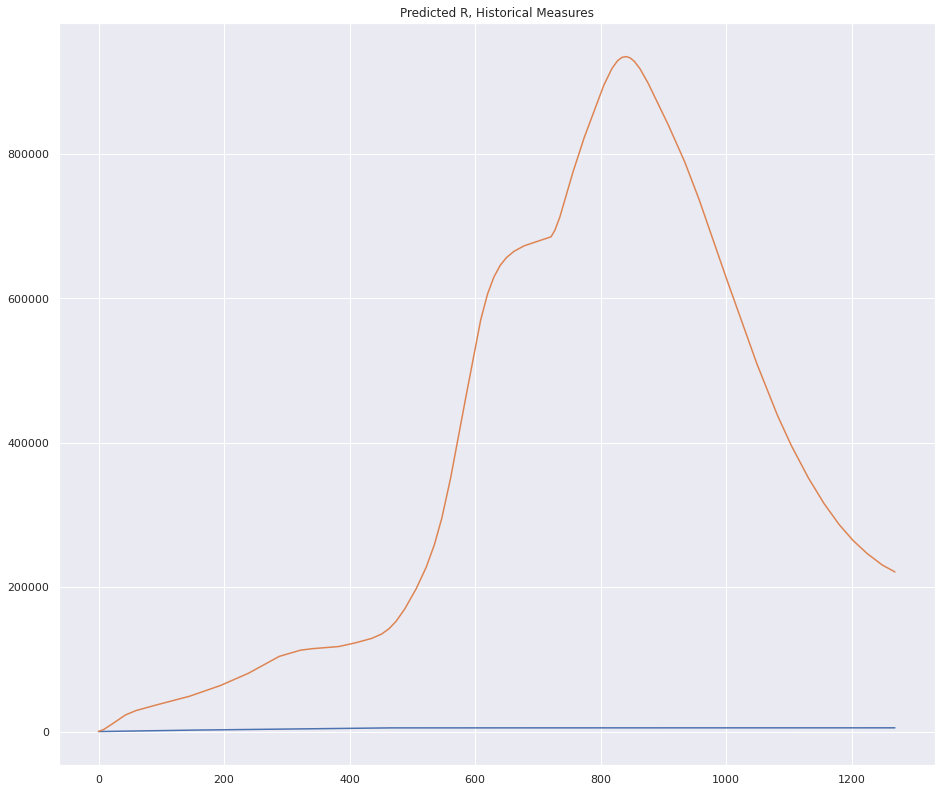

[1270, 1270, 1270, 1270, 1270, 1270, 1270, 1270, 1270, 1270, 1270, 1270]
Progress: 9.090909090909092%
Progress: 100.0%
SCENARIO RESULTS: PREDICTED R, HISTORICAL MEASURES
Infected: -4973691 5383834 15741360
Fatal: 54865 78048 101231
Peak Hospitalization Requirements: 3548 27889 52903
Peak ICU Requirements: 393 3642 9900
[0.         0.01012077 0.00228742 0.002843   0.00161388 0.00322225
 0.01720923 0.08353666 0.15980016 0.27091391]


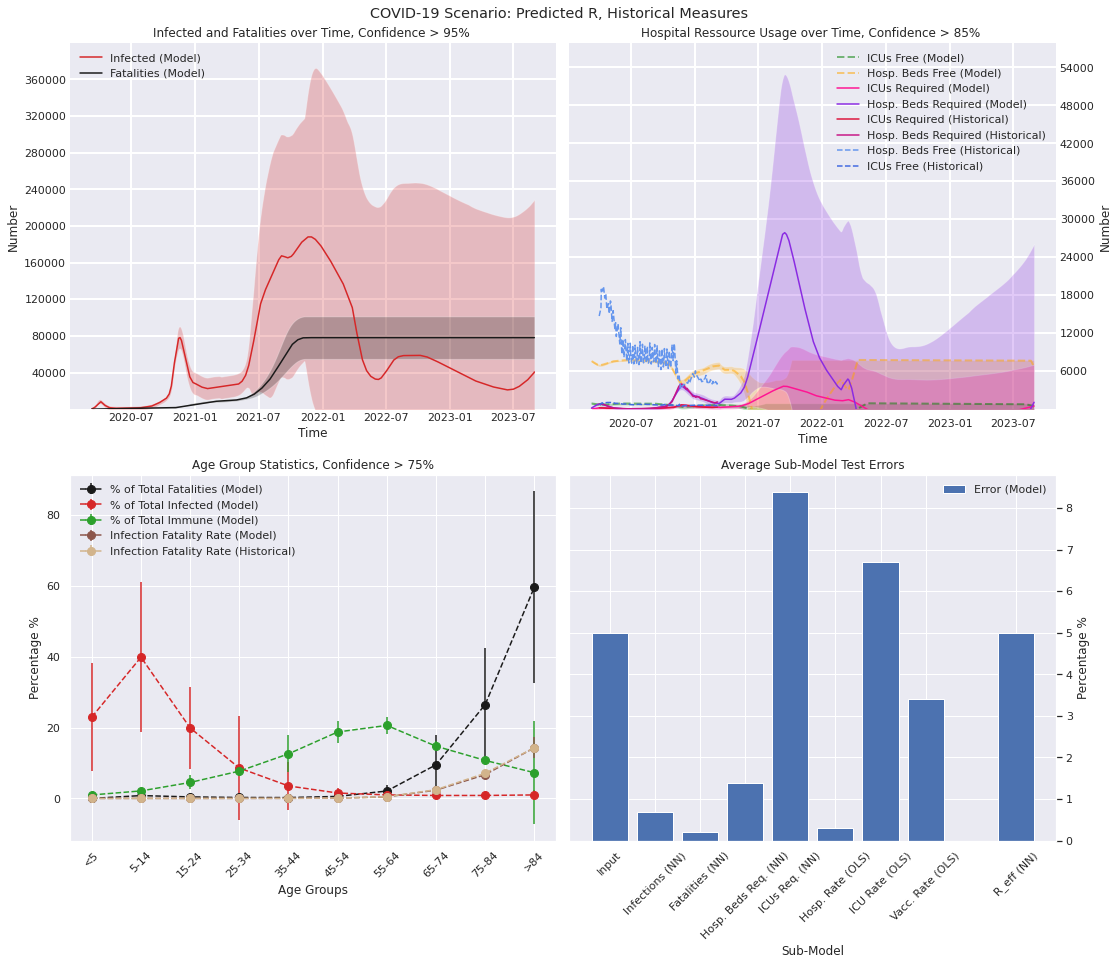

In [233]:
# Scenarios: Validate model with hisorical R data from 1 year of corona
# and compute what-if scenarios
# https://de.wikipedia.org/wiki/COVID-19-Pandemie_in_%C3%96sterreich#Ma%C3%9Fnahmen_im_Gesundheitsbereich
infected = aut_cov['Infected'].to_numpy()
fatal = aut_cov['Fatal'].to_numpy()
recovered = aut_cov['Recovered'].to_numpy()
t_vac_full_start = 317 #Full vaccinations 15.01.2021
t_vac_once_start = 298 #Full vaccinations 27.12.2020
duration = int(363*3.5)#len(aut_cov['Infected'].to_numpy())

scores = {'R2': r2_score,
          'EV': explained_variance_score,
          'RMSE': mean_squared_error,
          'RMSLE': mean_squared_log_error
         }


scenarios = {
    #'Historical R, Historical Measures' : [y_lwr, y, y_upr, scores],
    #
    'Predicted R, Historical Measures' : [
        res_lwr.predict(X_3yr), 
        res.predict(X_3yr),
        res_upr.predict(X_3yr), 
        scores],  
}

'''
X_orig = X.copy(deep=True)
for col in X_g.columns:
    if col not in irrelevant:
        X[col] = 0.0
        scenarios["No {}".format(col)] = [
            postprocess(y_lwr, res_lwr.predict(X)), 
            postprocess(y, res.predict(X)), 
            postprocess(y_upr, res_upr.predict(X)),  
            scores]
        X = X_orig.copy(deep=True)
    
    
for col in X_g.columns:
    if col not in irrelevant:
        X[col] = 0.0
scenarios["No Mitigation Measures"] = [
        postprocess(y_lwr, res_lwr.predict(X)), 
        postprocess(y, res.predict(X)), 
        postprocess(y_upr, res_upr.predict(X)),  
    scores]
X = X_orig.copy(deep=True)
'''
def is_fitted(model):
   # Source: https://stackoverflow.com/questions/39884009/whats-the-best-way-to-test-whether-an-sklearn-model-has-been-fitted/51200847
    attrs = [v for v in vars(model)
             if v.endswith("_") and not v.startswith("__")]
    
    return len(attrs) != 0


fitted =  True
topo = (duration, duration, duration, duration)
max_iter=1000
num_models = 10
score_threshold = 0.9
batch_size= 200
if fitted == False:
    res_infs = []
    res_fats = []
    res_hosps = []
    res_icus = []
    res_infs_r2 = []
    res_fats_r2 = []
    res_hosps_r2 = []
    res_icus_r2 = []
    for i in range(0,num_models):
        res_infs.append(MLPRegressor(max_iter=max_iter, 
                               hidden_layer_sizes = topo,
                               activation='relu', solver='adam',
                               learning_rate_init = 1e-3, shuffle=True,
                               tol=1e-6, early_stopping=True, validation_fraction=0.1,
                               batch_size=batch_size, warm_start= False, random_state = i
                              ))
        res_fats.append(MLPRegressor(max_iter=max_iter, 
                               hidden_layer_sizes = topo,
                               activation='relu', solver='adam',
                               learning_rate_init = 1e-3, shuffle=True,
                               tol=1e-6, early_stopping=True, validation_fraction=0.1,
                               batch_size=batch_size, warm_start= False, random_state = i
                              ))
        res_hosps.append(MLPRegressor(max_iter=max_iter, 
                               hidden_layer_sizes = topo,
                               activation='relu', solver='adam',
                               learning_rate_init = 1e-3, shuffle=True,
                               tol=1e-6, early_stopping=True, validation_fraction=0.1,
                               batch_size=batch_size//2, warm_start= False, random_state = i
                              ))
        res_icus.append(MLPRegressor(max_iter=max_iter, 
                               hidden_layer_sizes = topo,
                               activation='relu', solver='adam',
                               learning_rate_init = 1e-3, shuffle=True,
                               tol=1e-6, early_stopping=True, validation_fraction=0.1,
                               batch_size=batch_size//2, warm_start= False, random_state = i
                              ))


    
for scenario in scenarios:
    progress = 0.0
    print("SCENARIO: {}".format(scenario.upper()))
    print("Progress: {}%".format(progress))
    t = np.linspace(0, duration, duration).astype(int)
    
    R_eff_lwr = scenarios[scenario][0]
    R_eff = scenarios[scenario][1]
    R_eff_upr = scenarios[scenario][2]
    scoring = scenarios[scenario][3]
    
    S0, E0, I0, R0, F0, V10, V20 = pop_groups, infected[13]*2.4 ,infected[13] , recovered[13], fatal[13], 0, 0 #205 Covid Cases March 10 2020
    delta = [x*(1./14) for x in pop_groups_ifr] #Death without Recovery after 14 Days
    gamma = [((1.-x)/15) for x in pop_groups_ifr] #Recovery without Death after 14 Days
    epsilon = pop_groups_hosp_icu # ICU Probability of
    rho = pop_groups_hosp #Hsopitalization Probability
    
    ret_lwr = run_sim(S0, E0, I0, R0, F0, V10, V20, gamma, delta, epsilon, rho, t, deriv, 
                  t_vac_once_start, t_vac_full_start, R_eff_lwr)
    ret = run_sim(S0, E0, I0, R0, F0, V10, V20, gamma, delta, epsilon, rho, t, deriv, 
                  t_vac_once_start, t_vac_full_start, R_eff)
    ret_upr = run_sim(S0, E0, I0, R0, F0, V10, V20, gamma, delta, epsilon, rho, t, deriv, 
                  t_vac_once_start, t_vac_full_start, R_eff_upr)
    
    S_upr, E_upr, I_upr, R_upr, F_upr, V1_upr, V2_upr = 0, 0, 0, 0, 0, 0, 0
    S, E, I, R, F, V1, V2 = 0, 0, 0, 0, 0, 0, 0
    S_lwr, E_lwr, I_lwr, R_lwr, F_lwr, V1_lwr, V2_lwr = 0, 0, 0, 0, 0, 0, 0
        
    # Summarize Results
    for i in range(0,len(ret_upr),7):
        S_lwr+=ret_lwr[i]
        E_lwr+=ret_lwr[i+1]
        I_lwr+=ret_lwr[i+2]
        R_lwr+=ret_lwr[i+3]
        F_lwr+=ret_lwr[i+4]
        V1_lwr+=ret_lwr[i+5]
        V2_lwr+=ret_lwr[i+6]
        
        S+=ret[i]
        E+=ret[i+1]
        I+=ret[i+2]
        R+=ret[i+3]
        F+=ret[i+4]
        V1+=ret[i+5]
        V2+=ret[i+6]
        
        S_upr+=ret_upr[i]
        E_upr+=ret_upr[i+1]
        I_upr+=ret_upr[i+2]
        R_upr+=ret_upr[i+3]
        F_upr+=ret_upr[i+4]
        V1_upr+=ret_upr[i+5]
        V2_upr+=ret_upr[i+6]

    
    
    plt.plot(I, label='I')
    plt.plot(I_lwr, label='I_lwr')
    plt.plot(I_upr, label='I_upr')
    plt.plot(infected[13:363+13], label='hist')
    plt.legend()
    plt.show()
    plt.plot(F, label='F')
    plt.plot(R, label='R')
    plt.title(scenario)
    plt.show()
    

    print([len(l) for l in [I_upr, I, I_lwr, E_upr, E, E_lwr, R_upr, R, R_lwr, V2_upr, V2, V2_lwr]])
    # Extract Age Group Statistics:
    
    pct_fat_lwr, pct_fat, pct_fat_upr = [], [], []
    pct_inf_lwr, pct_inf, pct_inf_upr = [], [], []
    pct_ifr_lwr, pct_ifr, pct_ifr_upr = [], [], []
    pct_v_lwr, pct_v, pct_v_upr = [], [], []
    for i in range(0, aut_age_groups.shape[0], 1):
        pct_fat_lwr.append(ret_lwr[i*7+4][-1]/F_lwr[-1])
        pct_fat_upr.append(ret_upr[i*7+4][-1]/F_upr[-1])
        pct_fat.append(ret[i*7+4][-1]/F[-1])
        
        pct_inf_lwr.append((sum(ret_lwr[i*7+2])/14)/(sum(I_lwr)/14))
        pct_inf_upr.append((sum(ret_upr[i*7+2])/14)/(sum(I_upr)/14))
        pct_inf.append((sum(ret[i*7+2])/14)/(sum(I)/14))
        
        pct_ifr_lwr.append(ret_lwr[i*7+4][-1]/(sum(ret_lwr[i*7+2])/14))
        pct_ifr.append(ret[i*7+4][-1]/(sum(ret[i*7+2])/14))
        pct_ifr_upr.append(ret_upr[i*7+4][-1]/(sum(ret_upr[i*7+2])/14))
        
        pct_v_lwr.append(sum(ret_lwr[i*7+5]+ret_lwr[i*7+6]+ret_lwr[i*7+3])/(sum(V1_lwr)+sum(R_lwr)+sum(V2_lwr)))
        pct_v.append(sum(ret[i*7+5]+ret[i*7+6]+ret[i*7+3])/(sum(V1)+sum(R)+sum(V2)))
        pct_v_upr.append(sum(ret_upr[i*7+5]+ret_upr[i*7+6]+ret_upr[i*7+3])/(sum(V1_upr)+sum(R_upr)+sum(V2_upr)))
        
        # print(aut_age_groups['Altersgruppe'].iloc[i], 
        #      sum(ret[i*7+5]+ret[i*7+6]+ret[i*7+3])/(sum(V1)+sum(R)+sum(V2)))
              
                                       
        #print(aut_age_groups['Altersgruppe'].iloc[i],
        #      (sum(ret_lwr[i*7+2])/14)/(sum(I_lwr)/14),
        #      ret_lwr[i*7+4][-1]/F_lwr[-1])
        
        
    progress = 1.0/(num_models+1)
    print("Progress: {}%".format(progress*100))
    #d_inf = np.array([I_upr, I, I_lwr, E_upr, E, E_lwr, R_upr, R, R_lwr, V2_upr, V2, V2_lwr]).T
    #d_fat = np.array([F_upr, F, F_lwr, R_upr, R, R_lwr, V1_upr, V1, V1_lwr]).T
    d_inf = np.array([I_upr, I, I_lwr, E_upr, E, E_lwr, R_upr, R, R_lwr]).T
    d_fat = np.array([F_upr, F, F_lwr, R_upr, R, R_lwr]).T

    #scaler = MinMaxScaler()
    #d_inf = scaler.fit_transform(d_inf)
    #d_fat = scaler.fit_transform(d_fat)
    #from sklearn.preprocessing import normalize
    #d_inf = normalize(d_inf)
    #d_fat = normalize(d_fat)

    if scenario == 'Predicted R, Historical Measures' and fitted == False: 
            
        X_train_inf, X_test_inf, y_train_inf, y_test_inf = train_test_split(d_inf, 
                                                                            infected[13:363+13], 
                                                                            test_size=0.3)
        X_train_fat, X_test_fat, y_train_fat, y_test_fat = train_test_split(d_fat, 
                                                            fatal[13:363+13], 
                                                            test_size=0.3)
        X_train_hosp, X_test_hosp, y_train_hosp, y_test_hosp = train_test_split(d_inf[22:362], 
                                                            aut_hosp_groups['FZHosp'].to_numpy()[:340], 
                                                            test_size=0.3)
        X_train_icu, X_test_icu, y_train_icu, y_test_icu = train_test_split(d_inf[22:362], 
                                                            aut_hosp_groups['FZICU'].to_numpy()[:340], 
                                                            test_size=0.3)
        for i in range(0,num_models):
            if i < len(res_infs):
                res_infs[i].fit(X_train_inf, y_train_inf)
                score = res_infs[i].score(X_test_inf, y_test_inf)
                if score > score_threshold:
                    res_infs_r2.append(score)
                else:
                    del res_infs[i]
            
            if i < len(res_fats):
                res_fats[i].fit(X_train_fat, y_train_fat)
                score = res_fats[i].score(X_test_fat, y_test_fat)
                if score > score_threshold:
                    res_fats_r2.append(score)
                else:
                    del res_fats[i]
                
            if i < len(res_hosps):
                res_hosps[i].fit(X_train_hosp, y_train_hosp)
                score = res_hosps[i].score(X_test_hosp, y_test_hosp)
                if score > score_threshold:
                    res_hosps_r2.append(score)
                else:
                    del res_hosps[i]
            
            res_icus[i].fit(X_train_icu, y_train_icu)
            res_icus_r2.append(res_icus[i].score(X_test_icu, y_test_icu))
            progress = (2.0+i)/(num_models+1)
            print("Progress: {}%".format(progress*100))
        fitted = True
        print(len(res_infs), len(res_fats))
    else:
        progress = 100.0
        print("Progress: {}%".format(progress))
        
    infs, fats, hosps, icus = [], [], [], []
    for i in range(0,num_models):
        if i < len(res_infs) and is_fitted(res_infs[i]) and fitted:
            infs.append(res_infs[i].predict(d_inf))
        if i < len(res_fats) and is_fitted(res_fats[i]) and fitted:
            fats.append(res_fats[i].predict(d_fat))
        if i < len(res_hosps) and is_fitted(res_hosps[i]) and fitted:
            hosps.append(res_hosps[i].predict(d_inf))
        if i < len(res_icus) and is_fitted(res_icus[i]) and fitted:
            icus.append(res_icus[i].predict(d_inf))
    #for elem in infs:
    #    plt.plot(elem, label='infs')
    #    plt.show()
    
    z50, z75, z85, z90, z95, z97, z99 = 0.67449, 1.15035, 1.440, 1.64485, 1.95996, 2.17009, 3.29053
    input_err = 1.05 # Error of input data
    R_eff_est_err = 1.05 # Error of R_eff estimate
    hosp_est_err = 2.0-0.997 # Hospitalization rate estimation error
    icu_est_err = 2.0-0.933 # Hospitalization ICU rate estimation error
    vac1_err = 2.0-0.966 # Vaccinated once estimate error
    vac2_err = 2.0-0.966 # Vaccinated twice estimate error
    
    # Accumulated error of previous steps
    accumulated_err = input_err * R_eff_est_err * hosp_est_err * icu_est_err * vac1_err * vac2_err
    
    # NN Avg errors
    err_fats = 2.0 - sum(res_fats_r2)/len(res_fats_r2)
    err_infs = 2.0 - sum(res_infs_r2)/len(res_infs_r2)
    err_hosps = 2.0 - sum(res_hosps_r2)/len(res_hosps_r2)
    err_icus = 2.0 - sum(res_icus_r2)/len(res_icus_r2)

    inf_std = np.array(infs).std(axis=0)*accumulated_err*z95*err_infs
    inf_mean = np.array(infs).mean(axis=0)
    fat_std = np.array(fats).std(axis=0)*accumulated_err*z95*err_fats
    fat_mean = np.array(fats).mean(axis=0)
    hosp_std = np.array(hosps).std(axis=0)*accumulated_err*z85*err_hosps
    hosp_mean = np.array(hosps).mean(axis=0)
    icu_std = np.array(icus).std(axis=0)*accumulated_err*z85*err_icus
    icu_mean = np.array(icus).mean(axis=0)
    
    pct_inf_std = np.array([pct_inf,pct_inf_lwr,pct_inf_upr]).std(axis=0)*accumulated_err*z75*err_infs
    pct_inf_mean = np.array([pct_inf,pct_inf_lwr,pct_inf_upr]).mean(axis=0)
    pct_fat_std = np.array([pct_fat,pct_fat_lwr,pct_fat_upr]).std(axis=0)*accumulated_err*z75*err_fats
    pct_fat_mean = np.array([pct_fat,pct_fat_lwr,pct_fat_upr]).mean(axis=0)
    
    pct_ifr_std = np.array([pct_ifr,pct_ifr_lwr,pct_ifr_upr]).std(axis=0)*accumulated_err*z75*err_fats*err_infs
    pct_ifr_mean = np.array([pct_ifr,pct_ifr_lwr,pct_ifr_upr]).mean(axis=0)
    
    pct_v_std = np.array([pct_v,pct_v_lwr,pct_v_upr]).std(axis=0)*accumulated_err*z75*err_fats*err_infs
    pct_v_mean = np.array([pct_v,pct_v_lwr,pct_v_upr]).mean(axis=0)

    # Correct 'rising dead' problem', not even 25 Pfizer shots can do that...
    # Dissallow decrease of uncertainity
    # Cap max free hosp, ICU ressources.

    for i in range(1, fat_mean.shape[0]):
        if fat_mean[i] < fat_mean[i-1]:
            fat_mean[i] = fat_mean[i-1]
            
        if inf_std[i] < inf_std[i-1]:
            inf_std[i] = inf_std[i-1]
            
        if fat_std[i] < fat_std[i-1]:
            fat_std[i] = fat_std[i-1]
    
        if icu_std[i] < icu_std[i-1]:
            icu_std[i] = icu_std[i-1]
            
        if hosp_std[i] < hosp_std[i-1]:
            hosp_std[i] = hosp_std[i-1]

    hosp_free = [HOSPs_free]*len(F_lwr) - hosp_mean
    hosp_free_upr = [HOSPs_free]*len(F_lwr) - hosp_mean+hosp_std
    for i in range(0, hosp_free.shape[0]):
        if hosp_free_upr[i] > HOSPs_free:
            hosp_free_upr[i] = HOSPs_free
        if hosp_free[i] > HOSPs_free:
            hosp_free[i] = HOSPs_free
            
    icu_free = [ICUs_free]*len(F_lwr) - icu_mean
    icu_free_upr = [ICUs_free]*len(F_lwr) - icu_mean+icu_std
    for i in range(0, hosp_free.shape[0]):
        if icu_free_upr[i] > ICUs_free:
            icu_free_upr[i] = ICUs_free
        if icu_free[i] > ICUs_free:
            icu_free[i] = ICUs_free
    
    
    # Print Results
    print("SCENARIO RESULTS: {}".format(scenario.upper()))
    print('Infected:', 
          int(sum(inf_mean-inf_std)/14), 
          int(sum(inf_mean)/14), 
          int(sum(inf_mean+inf_std)/14))
    print('Fatal:', 
          int(np.amax(fat_mean-fat_std)), 
          int(np.amax(fat_mean)), 
          int(np.amax(fat_mean+fat_std)))
    print('Peak Hospitalization Requirements:', 
          int(np.amax(hosp_mean-hosp_std)), 
          int(np.amax(hosp_mean)), 
          int(np.amax(hosp_mean+hosp_std)))
    print('Peak ICU Requirements:', 
          int(np.amax(icu_mean-icu_std)), 
          int(np.amax(icu_mean)), 
          int(np.amax(icu_mean+icu_std)))
    #print(#pct_lwr*int(sum(inf_mean-inf_std)/14), 
    #      #pct*int(sum(inf_mean-inf_std)/14),
    #      pct_upr*int(sum(inf_mean-inf_std)/14))

    
    # Visualize Pandemic Curve
    sns.set(rc={'figure.figsize':(15.7*1.0,10.27*1.33)})
    base = datetime.datetime(2020, 3, 10, 00, 00)
    t = [base + datetime.timedelta(days=x) for x in range(duration)]
    fig, ((ax, ax2), (ax3, ax4)) = plt.subplots(2, 2)
    ax.yaxis.set_major_locator(ticker.MaxNLocator(10))
    ax.fill_between(t, inf_mean-inf_std, inf_mean+inf_std, facecolor='tab:red', alpha=0.25, interpolate=True)
    ax.plot(t, inf_mean, 'tab:red', label='Infected (Model)')
    ax.fill_between(t, fat_mean-fat_std, fat_mean+fat_std, facecolor='k', alpha=0.25, interpolate=True)
    ax.plot(t, fat_mean, 'k', label='Fatalities (Model)')
    
    #if scenario == 'Predicted R, Historical Measures' or scenario == 'Historical R, Historical Measures':
    #    ax.plot(t, infected[13:363+13], 'tab:blue', label='Infected (Historical)')
    #    ax.plot(t, fatal[13:363+13], 'tab:orange', label='Fatalities (Historical)')
    
    ax.set_xlabel('Time')
    ax.set_ylabel('Number')
    ax.set_ylim(1.0)
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend(loc='upper left')
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    ax.set_title("Infected and Fatalities over Time, Confidence > 95% ")
    fig.tight_layout()  

    # Visualize Hospital Ressoruces
    ax2.yaxis.set_major_locator(ticker.MaxNLocator(10))
    ax2.set_ylabel('Number')
    ax2.plot(t, icu_free,'green', alpha=0.5, lw=2, 
             label='ICUs Free (Model)', linestyle='dashed')
    ax2.fill_between(t, 
                     icu_free-icu_std, 
                     icu_free_upr,
                     facecolor='green', alpha=0.25, interpolate=True)
                     
    ax2.plot(t, hosp_free, 'orange', alpha=0.5, lw=2, 
             label='Hosp. Beds Free (Model)', linestyle='dashed')
    ax2.fill_between(t, 
                     hosp_free-hosp_std, 
                     hosp_free_upr,
                     facecolor='orange', alpha=0.25, interpolate=True)
                     
    ax2.fill_between(t, 
                     icu_mean-icu_std, 
                     icu_mean+icu_std, 
                     facecolor='deeppink', alpha=0.25, interpolate=True)
    ax2.plot(t, icu_mean, 'deeppink', 
           label='ICUs Required (Model)')
    ax2.fill_between(t, 
                     hosp_mean-hosp_std, 
                     hosp_mean+hosp_std,
                     facecolor='blueviolet', alpha=0.25, interpolate=True)               
    ax2.plot(t, hosp_mean, 'blueviolet', 
           label='Hosp. Beds Required (Model)')
    
    if scenario == 'Predicted R, Historical Measures' or scenario == 'Historical R, Historical Measures':
        ax2.plot(t[22:362], 
               aut_hosp_groups['FZICU'].to_numpy()[:340], 'crimson', 
               label='ICUs Required (Historical)')
        ax2.plot(t[22:362], 
               aut_hosp_groups['FZHosp'].to_numpy()[:340], 'mediumvioletred', 
               label='Hosp. Beds Required (Historical)')
        ax2.plot(t[22:362], 
               aut_hosp_groups['FZHospFree'].to_numpy()[:340], 'cornflowerblue', 
               label='Hosp. Beds Free (Historical)', linestyle='dashed')
        ax2.plot(t[22:362], 
               aut_hosp_groups['FZICUFree'].to_numpy()[:340], 'royalblue', 
               label='ICUs Free (Historical)', linestyle='dashed')
    
    ax2.tick_params(axis='y')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Number')
    ax2.set_ylim(1.0)
    ax2.yaxis.set_tick_params(length=0)
    ax2.yaxis.set_label_position("right")
    ax2.yaxis.tick_right()
    ax2.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax2.legend(loc='upper right')
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax2.spines[spine].set_visible(False)
    ax2.set_title("Hospital Ressource Usage over Time, Confidence > 85% ")
    
    # Visualize age group stats: TODO: Probably we should add SIR error here
    ax3.set_xlabel('Age Groups')
    ax3.set_ylabel('Percentage %')
    ax3.set_title('Age Group Statistics, Confidence > 75%')
    print(pct_fat_std)
    ax3.errorbar(x=np.linspace(1,len(pct_fat_mean), len(pct_fat_mean)).astype(int), 
            y=pct_fat_mean.T*100,
            xerr=0.0, yerr=pct_fat_std*100,
            marker='o', markersize=8, color='k', 
            ls =  '--', label='% of Total Fatalities (Model)')
    
    ax3.errorbar(x=np.linspace(1,len(pct_inf_mean), len(pct_inf_mean)).astype(int), 
            y=pct_inf_mean.T*100,
            xerr=0.0, yerr=pct_inf_std*100,
            marker='o', markersize=8, color='tab:red', 
            ls =  '--', label='% of Total Infected (Model)')
    
    ax3.errorbar(x=np.linspace(1,len(pct_v_mean), len(pct_v_mean)).astype(int), 
            y=pct_v_mean.T*100,
            xerr=0.0, yerr=pct_v_std*100,
            marker='o', markersize=8, color='tab:green', 
            ls =  '--', label='% of Total Immune (Model)')
    
    ax3.errorbar(x=np.linspace(1,len(pct_ifr_mean), len(pct_ifr_mean)).astype(int), 
            y=pct_ifr_mean.T*100,
            xerr=0.0, yerr=pct_ifr_std*100,
            marker='o', markersize=8, color='tab:brown', 
            ls =  '--', label='Infection Fatality Rate (Model)')
    
    if scenario == 'Predicted R, Historical Measures' or scenario == 'Historical R, Historical Measures':
        ax3.errorbar(x=np.linspace(1,len(aut_age_groups['IFR']), len(aut_age_groups['IFR'])).astype(int), 
                y=aut_age_groups['IFR'].T*100,
                xerr=0.0, yerr=0.0,
                marker='o', markersize=8, color='tan', 
                ls =  '--', label='Infection Fatality Rate (Historical)')
    
    ax3.set_xticks(np.linspace(1,len(pct_inf), len(pct_inf)).astype(int))
    ax3.set_xticklabels([label[0] for label in aut_age_groups['Altersgruppe']])
    for tick in ax3.get_xticklabels():
        tick.set_rotation(45)
    legend = ax3.legend(loc='upper left')
    legend.get_frame().set_alpha(0.5)
    
    
    # Visualize Model Intrinsic and Data Errors
    if scenario == 'Predicted R, Historical Measures' or scenario == 'Historical R, Historical Measures':
        errs = np.array([input_err-1.0, err_infs-1.0, err_fats-1.0, err_hosps-1.0, 
                err_icus-1.0, hosp_est_err-1.0, icu_est_err-1.0, (vac1_err + vac2_err)*0.5-1.0,
                R_eff_est_err-1.0
        ])*100
        err_labels = ['Input', 'Infections (NN)', 'Fatalities (NN)', 'Hosp. Beds Req. (NN)', 
                      'ICUs Req. (NN)', 'Hosp. Rate (OLS)', 'ICU Rate (OLS)', 'Vacc. Rate (OLS)', 'R_eff (NN)'
                     ]
        ax4.set_ylabel('Percentage %')
        ax4.set_title('Average Sub-Model Test Errors')
        ax4.set_xlabel('Error Source')
    else:
        errs = np.array([err_infs*(sum(inf_std)/len(inf_std)), err_fats*(sum(fat_std)/len(fat_std)), 
                         err_hosps*(sum(hosp_std)/len(hosp_std)), err_icus*(sum(icu_std)/len(icu_std))  
        ])*accumulated_err
        err_labels = ['Infections (NN)', 'Fatalities (NN)', 'Hosp. Beds Req. (NN)', 'ICUs Req. (NN)'
                     ]
        ax4.set_ylabel('Number')
        ax4.set_title('Scenario Specific Average Absolute Sub-Model Errors')
        ax4.set_xlabel('Sub-Model')
    
    
    ax4.set_xlabel('Sub-Model')
    ax4.yaxis.set_label_position("right")
    ax4.yaxis.tick_right()

    ax4.bar(x=np.linspace(0,len(errs), len(errs)).astype(int), 
            height=errs,
            label='Error (Model)')
    
    
    ax4.set_xticks(np.linspace(0,len(errs), len(errs)).astype(int))
    ax4.set_xticklabels(err_labels)
    for tick in ax4.get_xticklabels():
        tick.set_rotation(45)

    legend = ax4.legend(loc='upper right')
    legend.get_frame().set_alpha(0.5)
    
    fig.suptitle("COVID-19 Scenario: {}".format(scenario))
    fig.tight_layout()  
    fig.savefig(scenario)
    plt.show()
    # Done 100%: Seperate Ages Groups based on Output of SIR model proportionlly
    # TODO: Infer recovered, vaccinated, and so on
    # Done 50%: fix hospital requirements